<h1 align="center">CLASSIFYING CREDIT CARD USERS</h1>
<center><i>Devan Setya Putra<i></center>

    
**Dataset: [CLASSIFYING CREDIT CARD USERS](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=credit_card_default&page=table&pli=1&project=neat-simplicity-378402)**

# Query

        SELECT 
        CAST(limit_balance AS INT64) AS limit_balance, 
        CAST(sex AS INT64) AS sex, 
        CAST(education_level AS INT64) AS education_level, 
        CAST(marital_status AS INT64) AS marital_status, 
        CAST(age AS INT64) AS age, 
        CAST(pay_0 AS INT64) AS pay_0, 
        CAST(pay_2 AS INT64) AS pay_2, 
        CAST(pay_3 AS INT64) AS pay_3, 
        CAST(pay_4 AS INT64) AS pay_4, 
        CAST(pay_5 AS FLOAT64) AS pay_5, 
        CAST(pay_6 AS FLOAT64) AS pay_6, 
        CAST(bill_amt_1 AS INT64) AS bill_amt_1, 
        CAST(bill_amt_2 AS INT64) AS bill_amt_2, 
        CAST(bill_amt_3 AS INT64) AS bill_amt_3, 
        CAST(bill_amt_4 AS INT64) AS bill_amt_4, 
        CAST(bill_amt_5 AS INT64) AS bill_amt_5, 
        CAST(bill_amt_6 AS INT64) AS bill_amt_6, 
        CAST(pay_amt_1 AS INT64) AS pay_amt_1, 
        CAST(pay_amt_2 AS INT64) AS pay_amt_2, 
        CAST(pay_amt_3 AS INT64) AS pay_amt_3, 
        CAST(pay_amt_4 AS INT64) AS pay_amt_4, 
        CAST(pay_amt_5 AS INT64) AS pay_amt_5, 
        CAST(pay_amt_6 AS INT64) AS pay_amt_6, 
        CAST(default_payment_next_month AS INT64) AS default_payment_next_month
        FROM 
        bigquery-public-data.ml_datasets.credit_card_default 
        LIMIT 
        8000

* Dari query diatas, semua data ber type string diganti menjadi int
* yang mana 8000 dari (004= batch * 2000=tahun lahir)



# Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import  MinMaxScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import shapiro
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, roc_auc_score
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.outliers import Winsorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


#Model Saving
import joblib

# Display
# pd.options.display.max_rows = None
pd.options.display.max_columns = None


# Data Definition

## Data set Overview

        Terdapat beberapa kolom categorical, yaitu:
            - Sex
            - Education Level
            - Marital Status
            - pay
            - default_payment_next_month 

        Beikut Description dari data yang ada:
            - sex = (1=male, 2=female)    
            - education level = (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown) 
            - Marital status = (1=married, 2=single, 3=others) 
            - Pay = 
                -1 = pay duly;
                1 = payment delay for one month;
                2 = payment delay for two months; . . .;
                8 = payment delay for eight months;
                9 = payment delay for nine months and above.
                -2 = indicates no consumption in the month, and a value of
                0 = indicates the use of revolving credit (equivalent to prepayment)

            Repayment status merujuk pada status pembayaran pinjaman atau kredit tertentu pada waktu tertentu. Setiap baris mewakili catatan untuk satu pinjaman atau kredit, sementara nilai dalam kolom-kolom tersebut mengindikasikan status pembayaran pada bulan tertentu. Nilai yang digunakan untuk menggambarkan status pembayaran ini mungkin memiliki makna yang spesifik, tergantung pada jenis pinjaman atau kredit yang dimaksud dan konvensi yang digunakan dalam pengumpulan data. Misalnya, nilai positif mungkin mengindikasikan bahwa pembayaran telah dilakukan tepat waktu, sementara nilai negatif mungkin mengindikasikan keterlambatan dalam pembayaran.
            
            -  Default payment =(1=yes, 0=no) 

## Data Feature Selected Overview
    Terdapat beberapa feature yang digunakan yaitu:
            - credit_limit_category = category dari limit balance (0= low limit, 1= mid limit, 2= high limit, 3= very high limit) dibuat berdasarkan percentil
            - Total_pay = jumlah dari pay_amt 1-6 (di akumulasi)
            - Last_Bill = tagihan terakhir dari bill_amt 1 
            - pay_ratio = ratio pembayaran yang dihitung dengan rumus  (tagihan - pembayaran)/ limit balance 
            - Sex = (1=male, 2=female)    
            - education level = (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown) 
            - Marital status = (1=married, 2=single, 3=others) 
            - default_payment_next_month = (1=yes, 0=no) 1 untuk yang akan di bekukan bulan depan, sedangkan 0 untuk yang lancar (ini adalah target)


## Latar Belakang
    Dari data yang ada, terdapat berbagai  pengguna kartu kredit. Bank ingin melihat sebenarnya apa yang paling berpengaruh terhadap keputusan "dibekukan atau tidak". sehingga akan dilihat dan dicari apakah pengaruh terbesar terhadap pengambilan keputusan tersebut.

## Problem Statement
    Mengklasifikasikan tipe orang dan ratio dalam pembayaran tiap pengguna, menggunakan [LogisticRegression(), DecisionTreeClassifier(), SVC(), RandomForestClassifier(), GaussianNB(), KNeighborsClassifier(), AdaBoostClassifier()] agar melihat dan dibandingkan model mana yang terbaik dalam menentukan model dan melihat model mana yang dapat melihat hubungan /pengaruh-pengaruh dari feature-feature dalam menjelaskan dasar apa dilakukan keputusan "dibekukan atau tidak"
            

# Loading Data

In [3]:
# read CSV untuk memanggil data csv, dan missing value untuk memastikan bahwa tidak ada lagi uniq missing value
missing_values = ["n/a", "na", "--",' ?']
data=pd.read_csv("h8dsft_P1M1_Devan_Setya_Putra.csv", na_values = missing_values, skipinitialspace=True)
df= data.copy()
df.head(10) #melihat 10 data pertama

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000,1,6,1,54,0,0,0,0,0.0,0.0,61454,61808,62290,29296,26210,17643,2545,2208,1336,2232,542,348,1
1,200000,1,4,1,49,0,0,0,0,0.0,0.0,49221,49599,50942,50146,50235,48984,1689,2164,2500,3480,2500,3000,0
2,20000,2,6,2,22,0,0,0,0,0.0,0.0,19568,19420,15535,1434,500,0,4641,1019,900,0,1500,0,1
3,260000,2,4,2,33,0,0,0,0,0.0,0.0,18457,22815,27086,27821,30767,29890,5000,5000,1137,5000,1085,5000,0
4,150000,1,4,2,32,0,0,0,-1,0.0,0.0,159919,68686,161192,150464,143375,146411,4019,146896,157436,4600,4709,5600,0
5,300000,2,4,2,32,0,0,0,0,0.0,-1.0,54053,65235,64747,65150,-450,700,15235,1491,1303,0,2000,1400,0
6,130000,1,1,1,45,0,0,0,0,0.0,0.0,58180,59134,61156,62377,63832,65099,2886,2908,2129,2354,2366,2291,0
7,200000,1,1,1,58,0,0,0,0,0.0,0.0,192461,195970,122214,124647,126921,129167,7822,4417,4446,4597,4677,4698,0
8,500000,1,1,1,39,0,0,0,0,0.0,0.0,133598,167378,171106,174500,137406,204975,54209,4607,4603,5224,207440,7509,0
9,230000,1,1,1,48,0,0,0,0,0.0,0.0,160879,161797,165107,105508,108101,110094,7000,6607,3773,4290,4164,2000,0


In [4]:
df.tail(10) # melihat 10 data terakhir

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000,2,2,2,26,-1,-1,-1,-1,-2.0,-2.0,1968,459,2500,0,0,0,463,2500,0,0,0,0,0
2956,100000,1,3,1,40,0,0,-1,-1,-2.0,-2.0,12878,7702,2377,0,0,0,2000,2377,40000,0,0,0,0
2957,30000,2,3,1,48,1,-1,-1,-2,-2.0,-2.0,-100,100,0,0,0,0,200,0,0,0,0,0,0
2958,80000,2,3,1,39,-1,-1,-1,-1,-2.0,-1.0,5280,5000,5000,0,0,5000,5000,5000,0,5000,5000,470,0
2959,20000,1,3,2,26,-1,-1,-1,-2,-2.0,-2.0,96,780,0,0,0,0,1560,0,0,0,0,0,0
2960,80000,2,3,2,28,-1,-1,-1,-2,-2.0,-2.0,4280,2800,0,0,0,0,2800,0,0,0,0,0,0
2961,50000,2,3,1,51,-1,-1,-1,-1,-2.0,-2.0,752,300,5880,0,0,0,300,5880,0,0,0,0,1
2962,450000,2,2,1,38,-2,-2,-2,-2,-2.0,-2.0,390,390,390,390,390,390,390,780,390,390,390,390,1
2963,50000,2,2,1,44,-2,-2,-2,-2,-2.0,-2.0,1473,390,390,390,390,0,390,390,390,390,0,780,0
2964,290000,2,2,1,39,1,-2,-2,-2,-2.0,-2.0,-70,9540,390,3184,390,390,10000,800,3184,390,390,6617,0


In [5]:
# untuk melihat info apakah masih ada data string atau tidak
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   int64  
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   int64  
 5   pay_0                       2965 non-null   int64  
 6   pay_2                       2965 non-null   int64  
 7   pay_3                       2965 non-null   int64  
 8   pay_4                       2965 non-null   int64  
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   int64  
 12  bill_amt_2                  2965 non-null   int64  
 13  bill_amt_3                  2965 

# Cleaning Data

In [6]:
# untuk melihat apakah masih ada data missing value pada dataframe
df.isnull().sum()

limit_balance                 0
sex                           0
education_level               0
marital_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

In [7]:
# untuk melihat apakah terdapat data duplicate 
df[df.duplicated(keep=False)] 

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2806,200000,2,1,1,34,1,-2,-2,-2,-2.0,-2.0,0,0,0,0,0,0,0,0,0,0,0,0,0
2815,200000,2,1,1,34,1,-2,-2,-2,-2.0,-2.0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# karena terdapat data duplicate, maka salah satu data akan di hapus
df.drop_duplicates(inplace=True)

In [9]:
# code ini untuk melihat macam-macam dari nilai uniq yang ada di setiap kolom
for i in df.columns:
  print('Value Variabel {} is {}'.format(i,df[i].unique()))

Value Variabel limit_balance is [ 80000 200000  20000 260000 150000 300000 130000 500000 230000 460000
 780000 170000 320000 290000 240000 340000 360000 380000 180000 100000
  90000  50000 160000  70000 280000 220000  30000 120000  10000 470000
 310000 140000  60000 110000 430000 210000 490000 330000 250000 400000
 370000 440000 700000 530000 390000 410000 270000 560000  40000 680000
 480000 190000 350000 420000 510000 800000 450000 750000 620000]
Value Variabel sex is [1 2]
Value Variabel education_level is [6 4 1 2 3 5 0]
Value Variabel marital_status is [1 2 3 0]
Value Variabel age is [54 49 22 33 32 45 58 39 48 34 47 46 30 35 55 42 56 31 53 40 36 51 37 44
 24 38 26 25 23 27 28 29 41 63 50 43 66 61 52 62 69 21 65 57 64 67 60 59
 68]
Value Variabel pay_0 is [ 0  2  1 -1 -2  3  4  5  6  7  8]
Value Variabel pay_2 is [ 0 -1  2  3 -2  4  1  5  6  7]
Value Variabel pay_3 is [ 0  2 -2  3 -1  4  5  6  7]
Value Variabel pay_4 is [ 0 -1  2  3  4  5  6  7  8 -2]
Value Variabel pay_5 is [ 0.  

In [10]:
# sedangkan ini untuk melihat berapa jumlah uniq value ditiap kolom
for i in df.columns:
  print('total variation {} as much {}'.format(i,df[i].nunique()))

total variation limit_balance as much 59
total variation sex as much 2
total variation education_level as much 7
total variation marital_status as much 4
total variation age as much 49
total variation pay_0 as much 11
total variation pay_2 as much 10
total variation pay_3 as much 9
total variation pay_4 as much 10
total variation pay_5 as much 9
total variation pay_6 as much 8
total variation bill_amt_1 as much 2643
total variation bill_amt_2 as much 2592
total variation bill_amt_3 as much 2549
total variation bill_amt_4 as much 2504
total variation bill_amt_5 as much 2482
total variation bill_amt_6 as much 2461
total variation pay_amt_1 as much 1415
total variation pay_amt_2 as much 1372
total variation pay_amt_3 as much 1302
total variation pay_amt_4 as much 1214
total variation pay_amt_5 as much 1194
total variation pay_amt_6 as much 1189
total variation default_payment_next_month as much 2


In [11]:
# sedangkan ini untuk melihat kolom apa saja yang uniq valuenya dibawah 15
for i in df.columns:
  if len(df[i].unique()) < 15 :
    print(df[i].name)
    print(df[i].unique())
  else:
    continue

sex
[1 2]
education_level
[6 4 1 2 3 5 0]
marital_status
[1 2 3 0]
pay_0
[ 0  2  1 -1 -2  3  4  5  6  7  8]
pay_2
[ 0 -1  2  3 -2  4  1  5  6  7]
pay_3
[ 0  2 -2  3 -1  4  5  6  7]
pay_4
[ 0 -1  2  3  4  5  6  7  8 -2]
pay_5
[ 0.  2.  3.  4.  5.  6.  7. -1. -2.]
pay_6
[ 0. -1.  2.  3. -2.  4.  6.  7.]
default_payment_next_month
[1 0]


In [12]:
# Dilakukan penggantian karena  0 dan 3 merupakan data other, maka semua data other akan diubah menjadi 3 
df['marital_status'][df['marital_status']==0]=3
df['marital_status'].unique()

/var/folders/kt/0jyjyc0j4x55lktsjdv8ch3w0000gn/T/ipykernel_661/2676253694.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['marital_status'][df['marital_status']==0]=3


array([1, 2, 3])

In [13]:
# Dilakukan penggantian 0,4,5 dan 6 merupakan data unknown, maka semua data unknown akan diubah menjadi 4 (other)
df['education_level'][df['education_level']==0]=4
df['education_level'][df['education_level']==5]=4
df['education_level'][df['education_level']==6]=4
df['education_level'].unique()

/var/folders/kt/0jyjyc0j4x55lktsjdv8ch3w0000gn/T/ipykernel_661/3511415595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['education_level'][df['education_level']==0]=4
/var/folders/kt/0jyjyc0j4x55lktsjdv8ch3w0000gn/T/ipykernel_661/3511415595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['education_level'][df['education_level']==5]=4
/var/folders/kt/0jyjyc0j4x55lktsjdv8ch3w0000gn/T/ipykernel_661/3511415595.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

array([4, 1, 2, 3])

# EDA

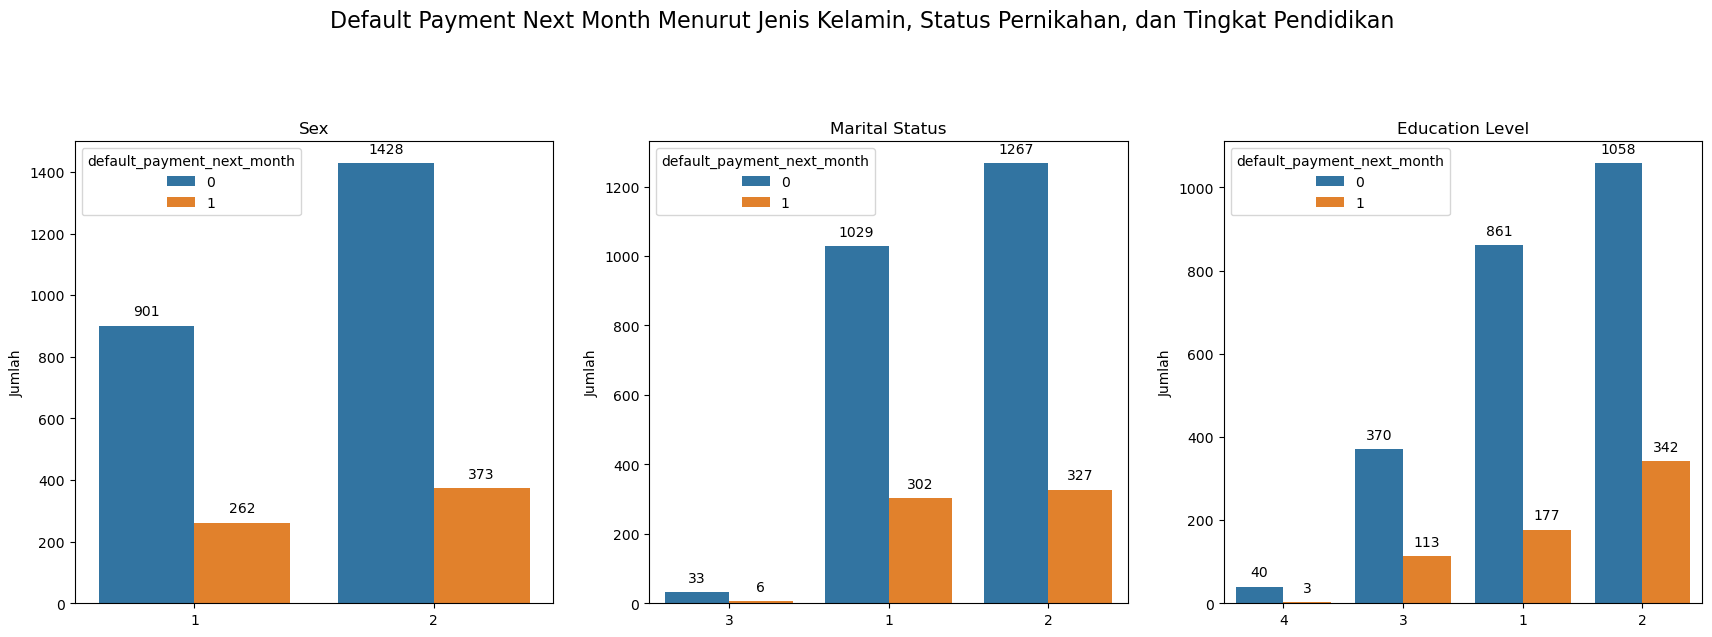

In [14]:
fig, axes = plt.subplots(ncols=3, figsize=(21,6))

sns.countplot(data=df, x='sex', hue='default_payment_next_month', order=df['sex'].value_counts(ascending=True).index, ax=axes[0])
sns.countplot(data=df, x='marital_status', hue='default_payment_next_month', order=df['marital_status'].value_counts(ascending=True).index, ax=axes[1])
sns.countplot(data=df, x='education_level', hue='default_payment_next_month', order=df['education_level'].value_counts(ascending=True).index, ax=axes[2])

for i in range(3):
    ax = axes[i]
    ax.set_title(ax.get_xlabel().replace('_', ' ').title())
    ax.set_xlabel('')
    ax.set_ylabel('Jumlah')
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(format(height, '.0f'), 
                    xy=(p.get_x() + p.get_width() / 2., height),
                    xytext=(0, 5),
                    textcoords='offset points',
                    ha='center',
                    va='bottom')
plt.suptitle('Default Payment Next Month Menurut Jenis Kelamin, Status Pernikahan, dan Tingkat Pendidikan', fontsize=16, y=1.1)
plt.show()

Masuk pada EDA, plot diatas melihat pengguna kredit card yang akan dibekukan berdasarkan 3 kategori
1. sex= dapat dilihat bahwa pengguna kredit card lebih banyak adalah perempuan dan karena populasi penggunanya lebih banyak, pengguna yang credit card nya akan di bekukan juga lebih banyak perempuan. itu bisa terjadi mungkin karena pengeluaran perempuan lebih banyak terutama untuk mereka yang harus membeli peralatan kecantikan yang tidak murah dan mungkin karena pemasukan mereka juga yang belum bisa mencukupi kebutuhan mereka.

2. marital_status = dapat dilihat bahwa pengguna kredit card lebih banyak adalah single atau belum menikah dan karena populasi penggunanya lebih banyak, pengguna yang credit card nya akan di bekukan juga lebih banyak single atau belum menikah. itu bisa terjadi mungkin karena pendapatan yang masih single masih belum stabil sehingga banyakk yang memerlukan pinjaman dan tidak mampu membayar.

3. education_level = dapat dilihat bahwa pengguna kredit card lebih banyak adalah lulusan university  dan karena populasi penggunanya lebih banyak, pengguna yang credit card nya akan di bekukan juga lebih banyak lulusan university . itu bisa terjadi mungkin karena jumlah populasi yang besar dan gaya hidup yang lumayan besar yang mengakibatkan sering melakukan pinjaman kredit dan sulit membayar.

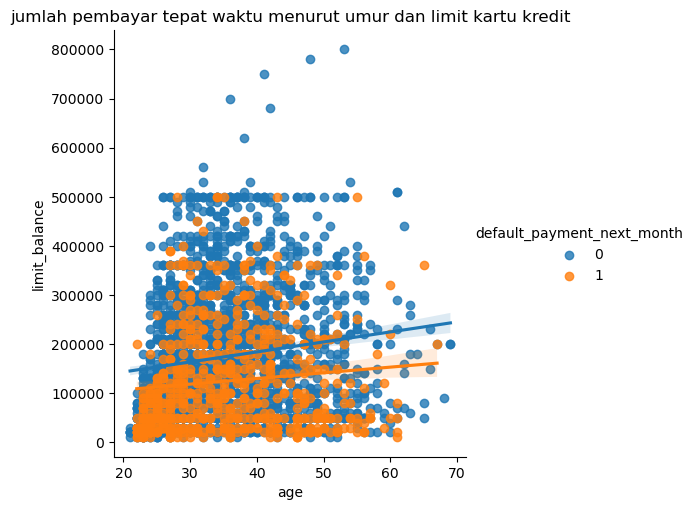

In [15]:
# ingin melihat bentuk data
sns.lmplot(x="age", y="limit_balance", hue="default_payment_next_month", data=df)

plt.title("jumlah pembayar tepat waktu menurut umur dan limit kartu kredit")

plt.show()

`Dilihat dari polanya, data limit balance dan age tidak terlihat pola linear`

### Melihat hubungan pay, bill amount and pay amount

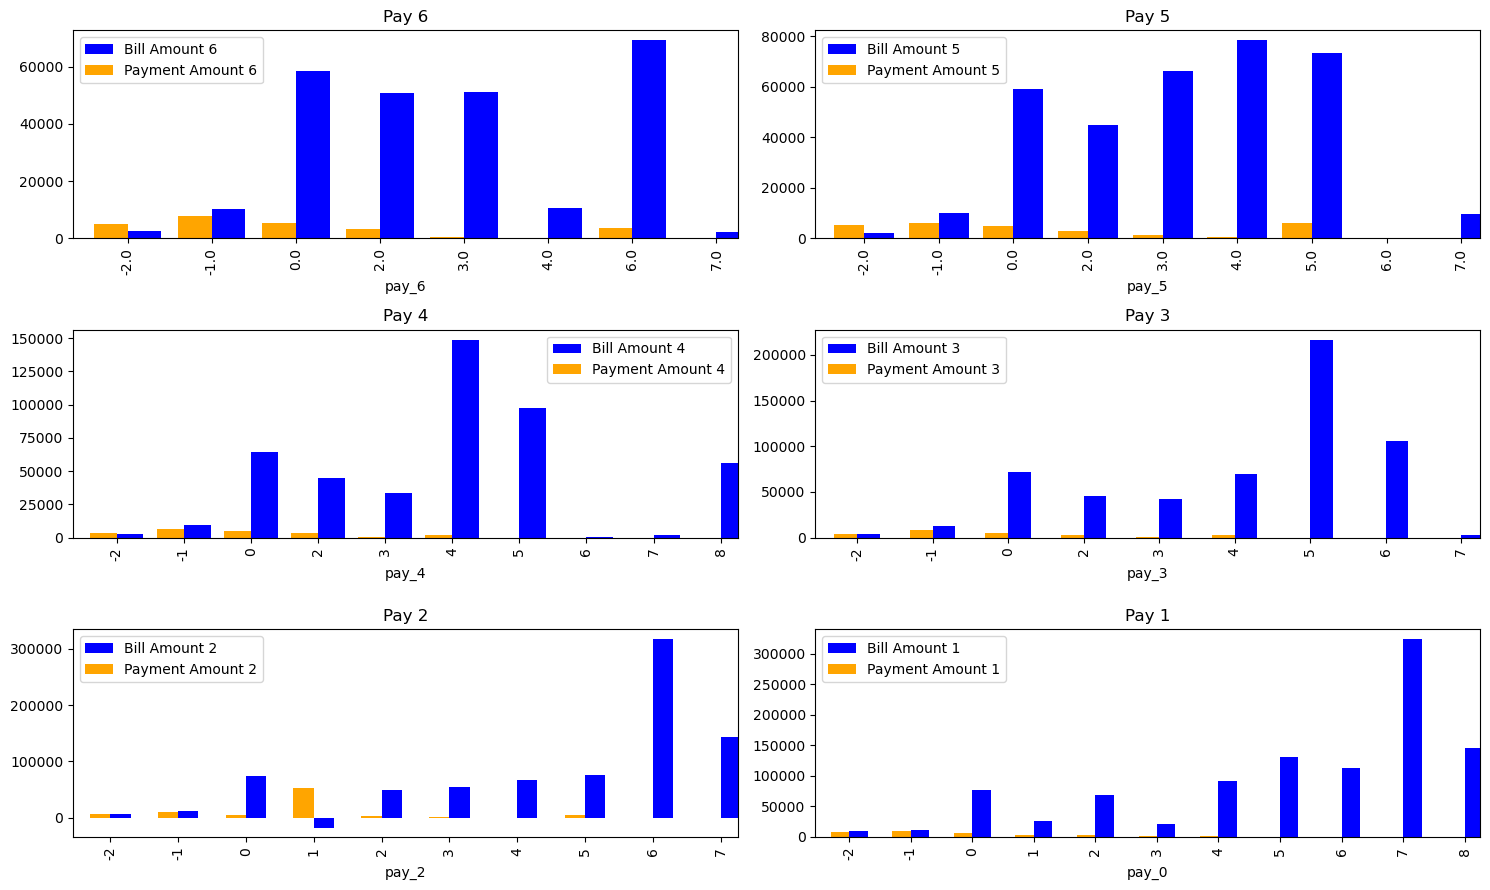

In [16]:
fig, axs = plt.subplots(3, 2, figsize=(15, 9))

# Plot 1
df.groupby('pay_6')['bill_amt_6'].mean().plot(kind='bar', ax=axs[0, 0], position=0, width=0.4, color='blue', label='Bill Amount 6')
df.groupby('pay_6')['pay_amt_6'].mean().plot(kind='bar', ax=axs[0, 0], position=1, width=0.4, color='orange', label='Payment Amount 6')
axs[0, 0].legend()
axs[0, 0].set_title('Pay 6')

# Plot 2
df.groupby('pay_5')['bill_amt_5'].mean().plot(kind='bar', ax=axs[0, 1], position=0, width=0.4, color='blue', label='Bill Amount 5')
df.groupby('pay_5')['pay_amt_5'].mean().plot(kind='bar', ax=axs[0, 1], position=1, width=0.4, color='orange', label='Payment Amount 5')
axs[0, 1].legend()
axs[0, 1].set_title('Pay 5')

# Plot 3
df.groupby('pay_4')['bill_amt_4'].mean().plot(kind='bar', ax=axs[1, 0], position=0, width=0.4, color='blue', label='Bill Amount 4')
df.groupby('pay_4')['pay_amt_4'].mean().plot(kind='bar', ax=axs[1, 0], position=1, width=0.4, color='orange', label='Payment Amount 4')
axs[1, 0].legend()
axs[1, 0].set_title('Pay 4')

# Plot 4
df.groupby('pay_3')['bill_amt_3'].mean().plot(kind='bar', ax=axs[1, 1], position=0, width=0.3, color='blue', label='Bill Amount 3')
df.groupby('pay_3')['pay_amt_3'].mean().plot(kind='bar', ax=axs[1, 1], position=1, width=0.3, color='orange', label='Payment Amount 3')
axs[1, 1].legend()
axs[1, 1].set_title('Pay 3')

# Plot 5
df.groupby('pay_2')['bill_amt_2'].mean().plot(kind='bar', ax=axs[2, 0], position=0, width=0.3, color='blue', label='Bill Amount 2')
df.groupby('pay_2')['pay_amt_2'].mean().plot(kind='bar', ax=axs[2, 0], position=1, width=0.3, color='orange', label='Payment Amount 2')
axs[2, 0].legend()
axs[2, 0].set_title('Pay 2')

# Plot 6
df.groupby('pay_0')['bill_amt_1'].mean().plot(kind='bar', ax=axs[2, 1], position=0, width=0.3, color='blue', label='Bill Amount 1')
df.groupby('pay_0')['pay_amt_1'].mean().plot(kind='bar', ax=axs[2, 1], position=1, width=0.3, color='orange', label='Payment Amount 1')
axs[2, 1].legend()
axs[2, 1].set_title('Pay 1')

plt.tight_layout()
plt.show()


Masuk pada EDA, plot diatas melihat pola pembayaran yang sudah dikategorikan menurut pay 0-6
- -2 = dilihat dari polanya dari bulan april sampai september, -2 merupakan mereka yang rutin membayar dan kemungkinan melakukan prepayment (bayar sebelum jatuh tempo) karena jumlah tagihan cenderung lebih kecil dibandingkan yang dibayar
- -1 = dilihat dari polanya dari bulan april sampai september, -1 merupakan mereka yang rutin membayar tepat waktu sesuai dengan tagihannya karena jumlah tagihan cenderung imbang dibandingkan yang dibayar
- 0 = dilihat dari polanya dari bulan april sampai september, 0 merupakan mereka yang rutin membayar tepat waktu namun tidak sesuai dengan tagihannya, atau kurang dari yang seharusnya dibayarkan karena jumlah tagihan lebih banyak dibandingkan yang dibayar namun dari setiap bulan selalu ada pembayaran
- 1-8 = dilihat dari polanya dari bulan april sampai september, 1-8 merupakan mereka yang menunggak membayatr 1= nunggak 1 bulan, 2=nunggak 2bulan dan seterusnya. karena polanya yang lebih besar tagihan dan terkadang ada yang tidak membayar.


### Pembuatan column category limit balance berdasarkan quartile data

In [17]:
df['limit_balance'].describe()

count      2964.000000
mean     163356.950067
std      125049.701016
min       10000.000000
25%       50000.000000
50%      140000.000000
75%      230000.000000
max      800000.000000
Name: limit_balance, dtype: float64

In [18]:
# # pengkategorian limit_balance
def add_credit_limit_category(df, balance_col):
    # copy the dataframe to avoid modifying the original
    dataset = np.array(df[balance_col])

    # create a new column based on the conditions
    conditions = [
        dataset <= 50000,
        np.logical_and(dataset > 50000, dataset <= 140000),
        np.logical_and(dataset > 140000, dataset <= 230000),
        dataset > 230000
    ]
    choices = [0, 1, 2, 3] # 0= low limit, 1= mid limit, 2= high limit, 3= very high limit
    df['credit_limit_category'] = np.select(conditions, choices)
    
    return df

In [19]:
add_credit_limit_category(df, 'limit_balance').head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month,credit_limit_category
0,80000,1,4,1,54,0,0,0,0,0.0,0.0,61454,61808,62290,29296,26210,17643,2545,2208,1336,2232,542,348,1,1
1,200000,1,4,1,49,0,0,0,0,0.0,0.0,49221,49599,50942,50146,50235,48984,1689,2164,2500,3480,2500,3000,0,2
2,20000,2,4,2,22,0,0,0,0,0.0,0.0,19568,19420,15535,1434,500,0,4641,1019,900,0,1500,0,1,0
3,260000,2,4,2,33,0,0,0,0,0.0,0.0,18457,22815,27086,27821,30767,29890,5000,5000,1137,5000,1085,5000,0,3
4,150000,1,4,2,32,0,0,0,-1,0.0,0.0,159919,68686,161192,150464,143375,146411,4019,146896,157436,4600,4709,5600,0,2


`hal ini dilakukan agar pengguna credit card yang memiliki limit balance tertinggi tidak dianggap sebagai outliers dan mereka bisa tetap dipakai dalam model predict.`

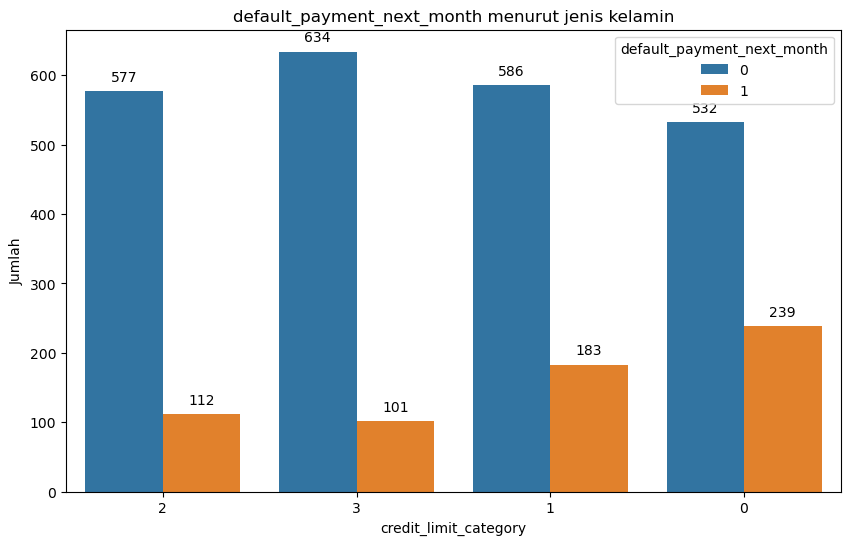

In [20]:
plt.figure(figsize=(10, 6))
ax_credit_limit_category = sns.countplot(data=df, x='credit_limit_category', hue='default_payment_next_month', order=df['credit_limit_category'].value_counts(ascending=True).index)

for p in ax_credit_limit_category.patches:
    height = p.get_height()
    ax_credit_limit_category.annotate(format(height, '.0f'), 
                          xy=(p.get_x() + p.get_width() / 2., height),
                          xytext=(0, 5),
                          textcoords='offset points',
                          ha='center',
                          va='bottom')

plt.title('default_payment_next_month menurut jenis kelamin')
plt.xlabel('credit_limit_category')
plt.ylabel('Jumlah')
plt.show()

`diatas merupakan plot dari pengkategorian limit balance. dapat dilihat bahwa pengguna yang lancar membayar terus menerus adalah mereka yang memiliki limit balance yang besar. namun yang paling kecil adalah mereka yang memiliki limit balance terkecil serta mereka yang paling banyak yang akan di bekukan.`

<AxesSubplot: xlabel='limit_balance', ylabel='Count'>

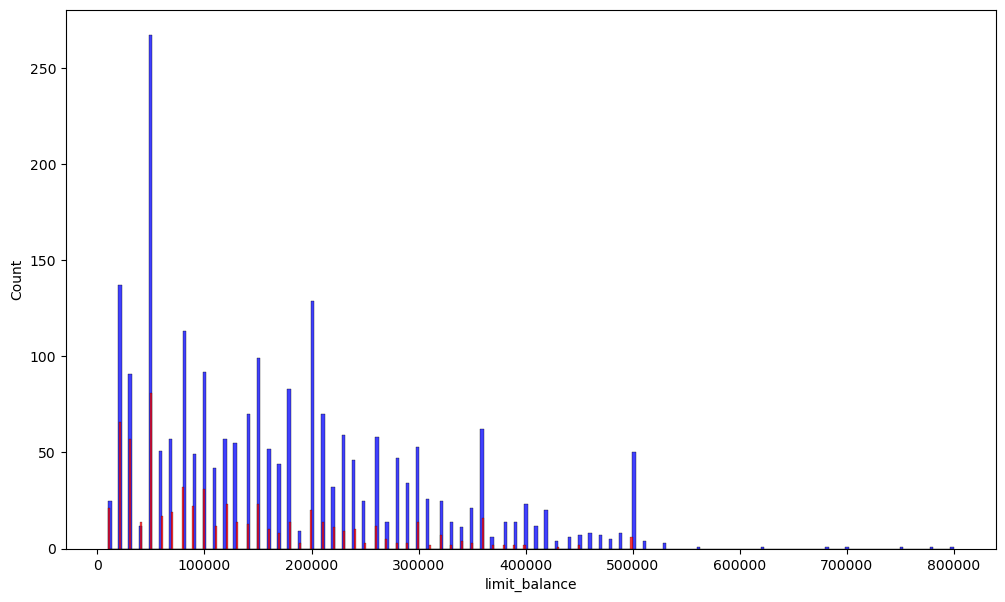

In [21]:
plt.figure(figsize=(12,7))
default_df        = df[df['default_payment_next_month'] == 1]
nodefault_df      = df[df['default_payment_next_month'] == 0]

sns.histplot(nodefault_df['limit_balance'], bins = 250, color = 'b')
sns.histplot(default_df['limit_balance'], bins = 250, color = 'r')

`diatas merupakan plot dari limit balance. dapat dilihat bahwa jumlah pengguna mayoritas berada di sekitaran 50,000 dan paling banyak dikategorikan akan dibekukan paling banyak juga pada sekitaran 50,000 pada limit balance`

<AxesSubplot: xlabel='age', ylabel='count'>

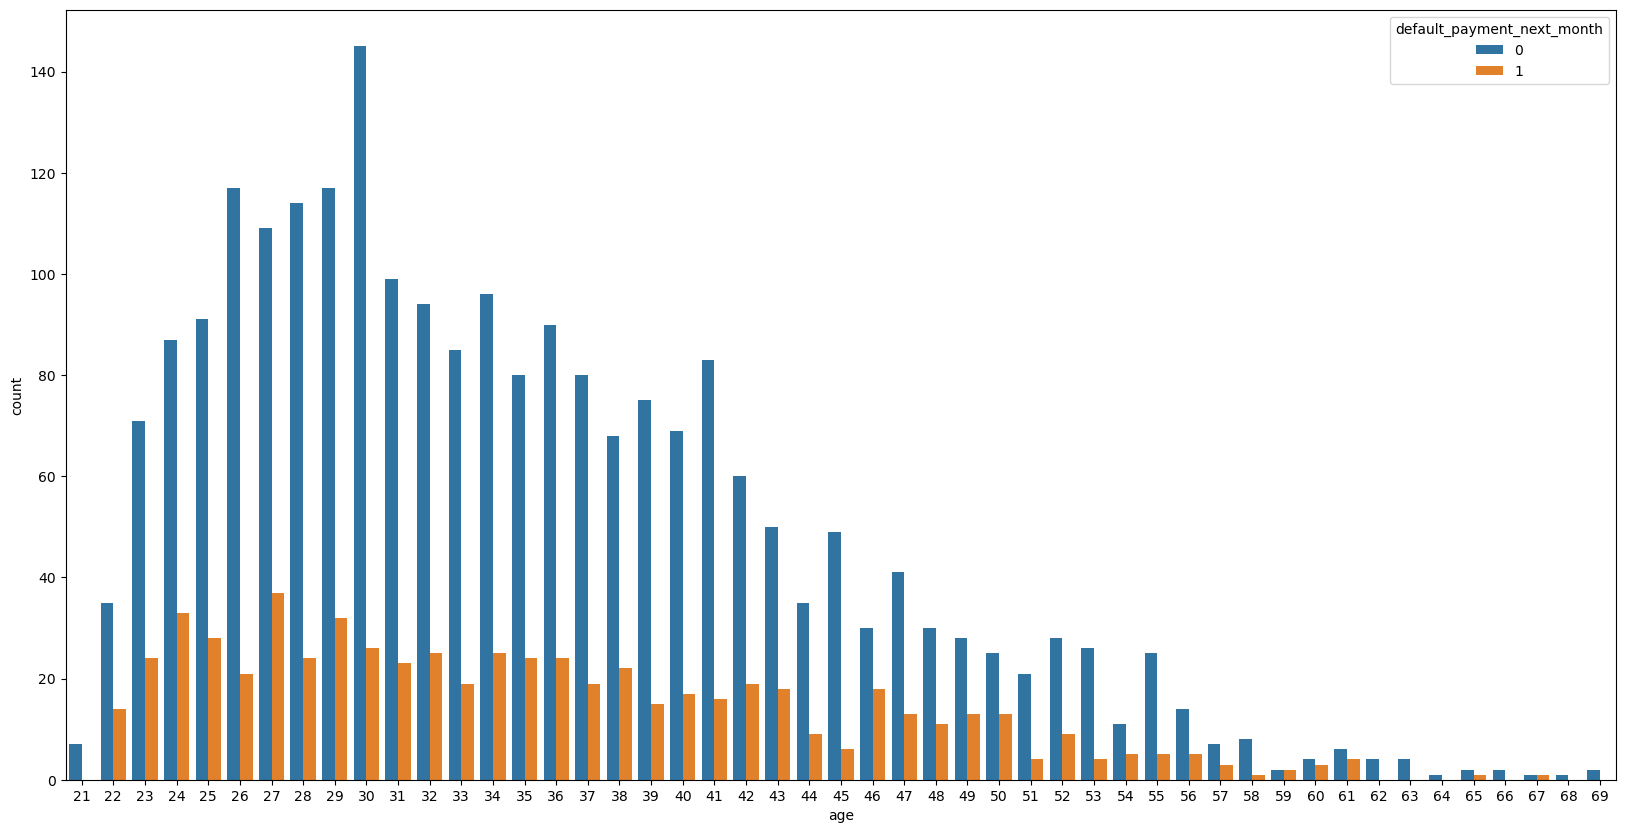

In [22]:
plt.figure(figsize=[20, 10])
sns.countplot(x = 'age', hue = 'default_payment_next_month', data = df)

`diatas merupakan plot dari limit balance. dapat dilihat bahwa jumlah pengguna mayoritas umur produktif yang mana dari umur 24- 34 dan puncaknya pada umur 30 dan pada umur 30 mayoritas aman dan lancar pada pembayaran. namun untuk jumlah pengguna yang akan dibekukan paling banyak berada di umur 27`

# Features Selection

## Correlation

<AxesSubplot: >

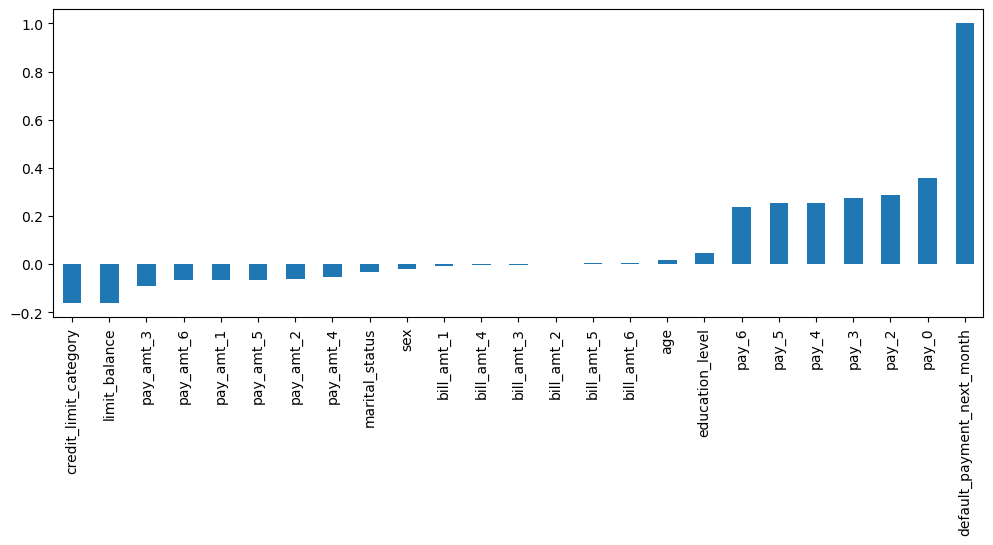

In [23]:
plt.figure(figsize=(12,4))
df.corr()['default_payment_next_month'][:].sort_values().plot(kind='bar')

`Plot diatas merupakan plot correlation yang melihat hubungan positif dan negatif dari feature yang ada terhadap target. yang mana yang memiliki correlation kecil adalah bill amount 1-6 sedangkan terbesar positif adalah pay 0 dan terbesar negatif atalah credit limit category`

### Correlation heatmap

In [24]:
cols1= ['limit_balance', 'sex', 'education_level', 'marital_status', 'age','credit_limit_category' ,'default_payment_next_month']
cols2= ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6','default_payment_next_month']
cols3= ['bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6','default_payment_next_month']
cols4= ['pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6','default_payment_next_month']

<AxesSubplot: >

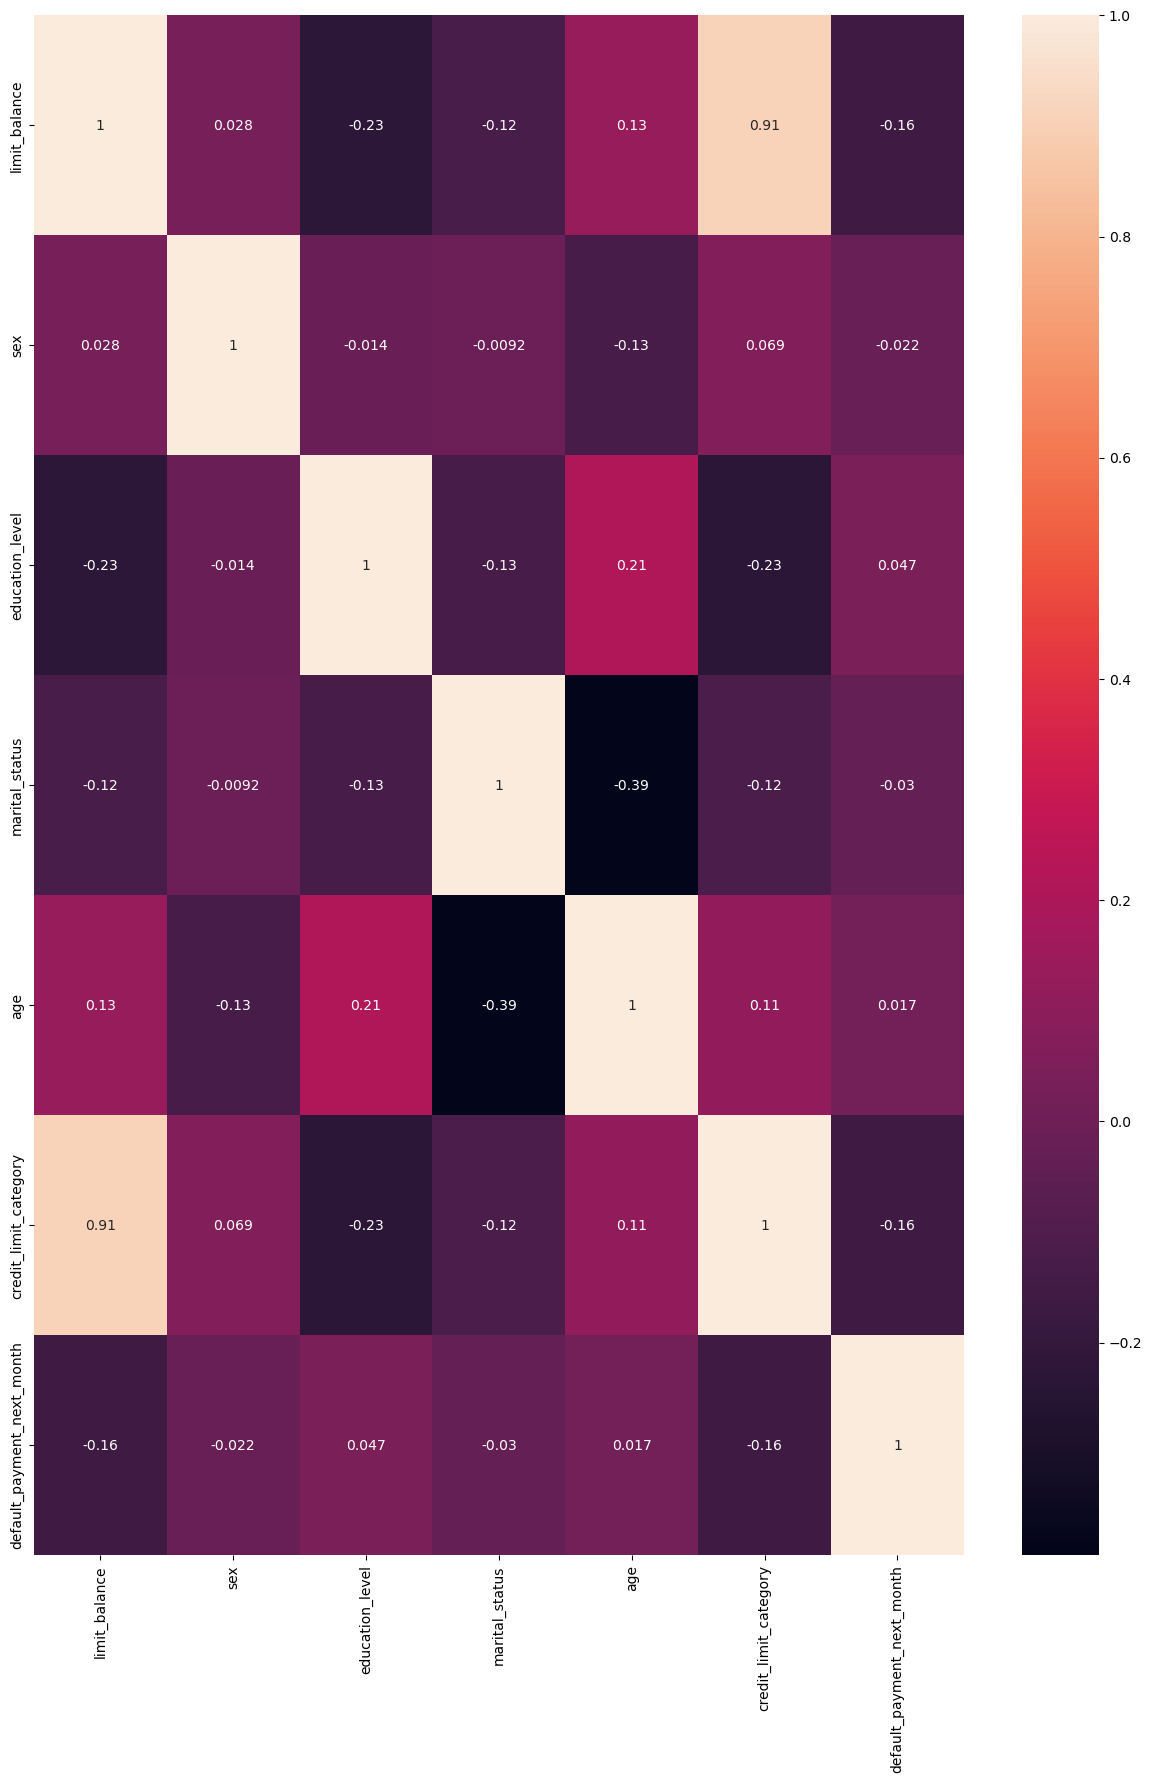

In [25]:
plt.figure(figsize=(15,20))
sns.heatmap(df[cols1].corr(),annot=True)

<AxesSubplot: >

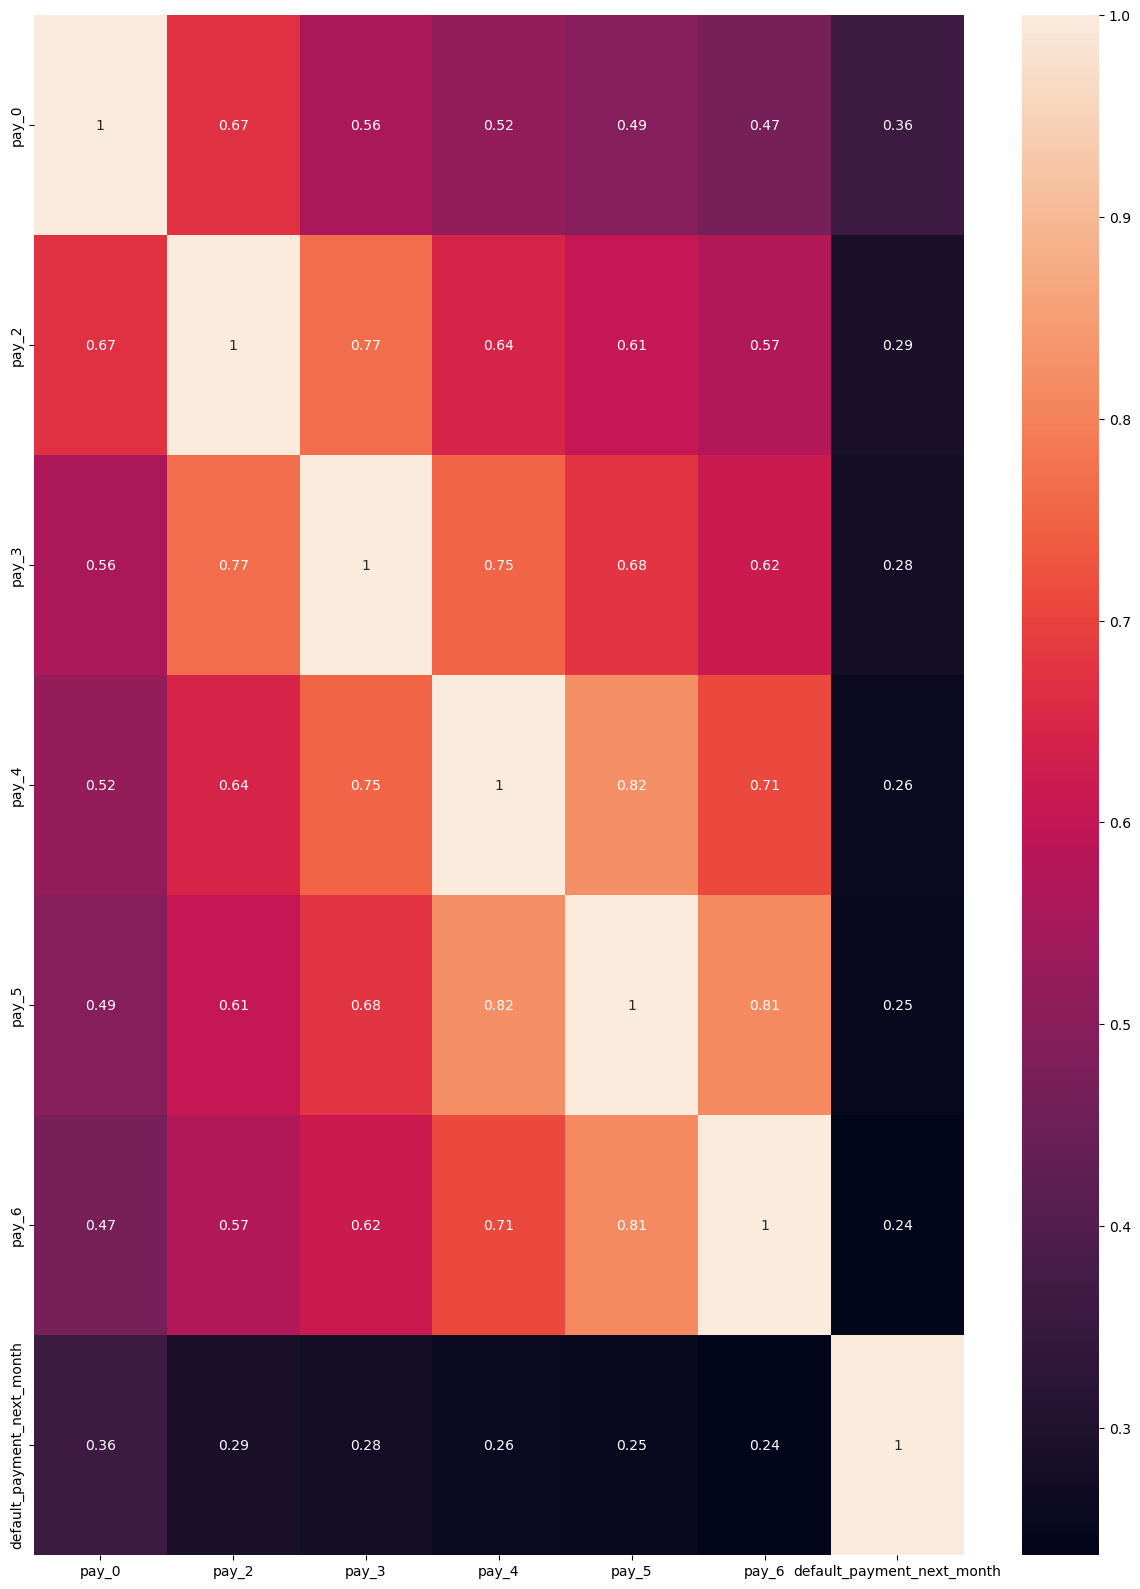

In [26]:
plt.figure(figsize=(15,20))
sns.heatmap(df[cols2].corr(),annot=True)

<AxesSubplot: >

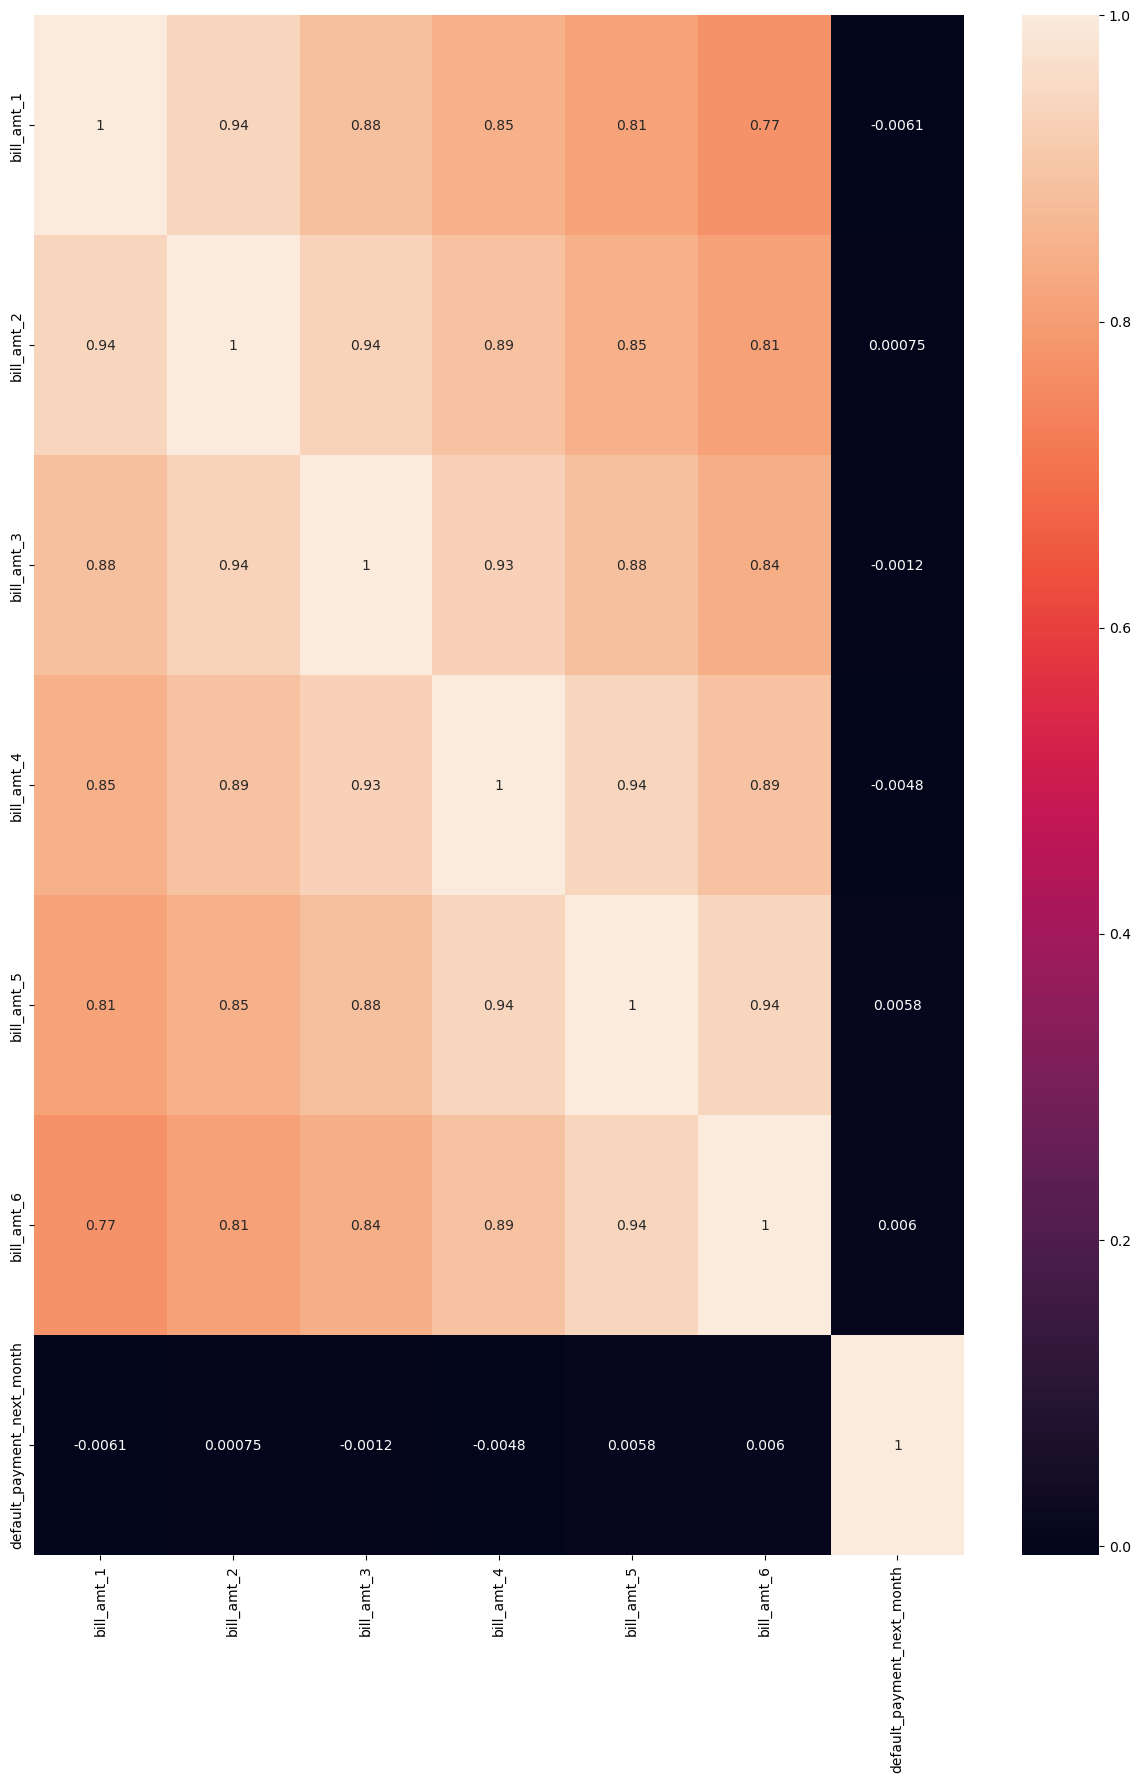

In [27]:
plt.figure(figsize=(15,20))
sns.heatmap(df[cols3].corr(),annot=True)

<AxesSubplot: >

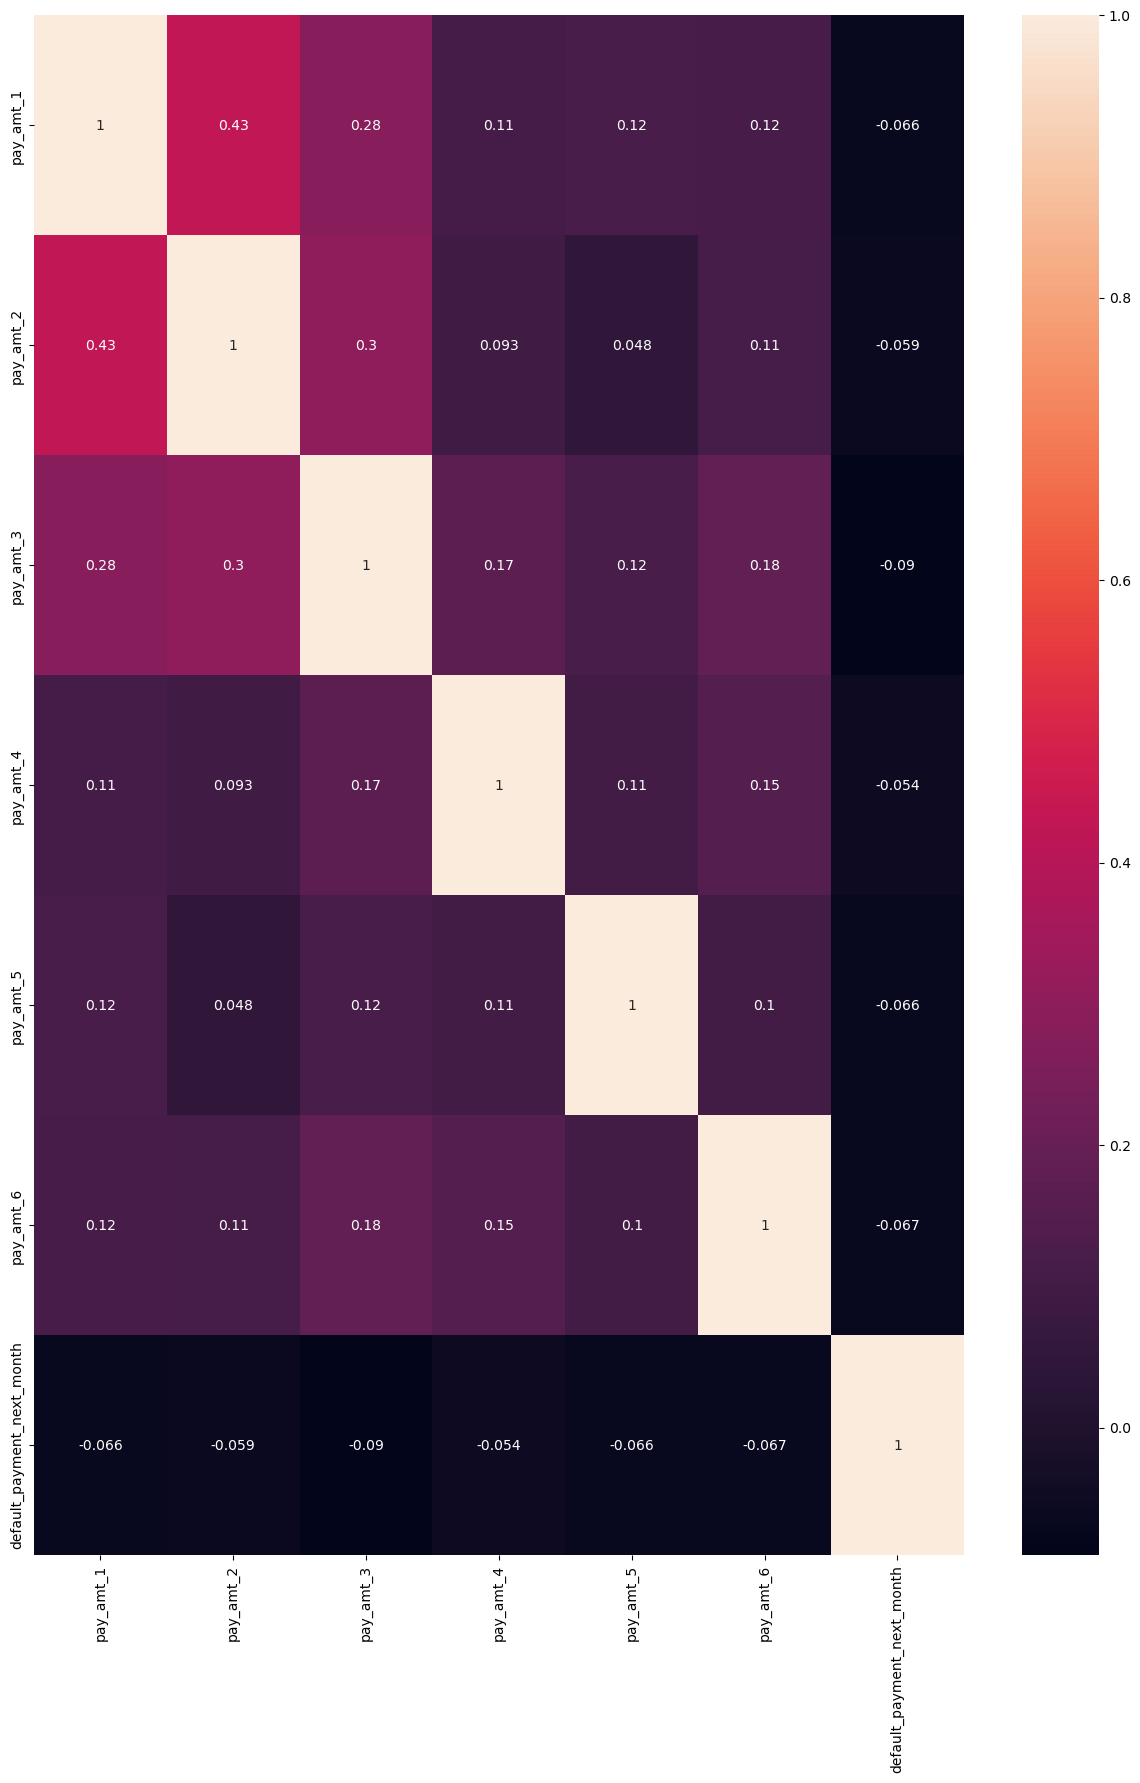

In [28]:
plt.figure(figsize=(15,20))
sns.heatmap(df[cols4].corr(),annot=True)

- Diatas merupakan heatmap yang dipisahkan menjadi 4, yang mana dapat dilihat bahwa bill amount memiliki hubungan yang sangat besar antar feature sehingga Diputuskan untuk hanya mengambil data bill amount terakhir agar tidak terdapat multikolinearitas
- sedangkan untuk pay amount 1-6 akan dijumlahkan agar melihat total dari semua pembayaran yang dilakukan selama april-september
- untuk data pay 0-6 tidak akan dipakai, walaupun hubungan correlation besar, namun karena tidak digunakan bill amt dan pay amt dari bulan yang sama, maka pay 0-6 tidak akan digunakan dalam model
- untuk data limit balance tidak akan dipakai, namun yang digunakan adalah limit balance category, agar nilai terbesar yang ada di limit balance tidak dianggap sebagai outliers
- untuk feature lainnya akan dipakai 


## Act after Correlation

In [29]:
# Pembuatan kolom bill terakhir
def total_pay(df):
    df['total_pay'] = (df['pay_amt_1']+df['pay_amt_2']+df['pay_amt_3']+df['pay_amt_4']+df['pay_amt_5']+df['pay_amt_6'])
    return df

In [30]:
total_pay(df)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month,credit_limit_category,total_pay
0,80000,1,4,1,54,0,0,0,0,0.0,0.0,61454,61808,62290,29296,26210,17643,2545,2208,1336,2232,542,348,1,1,9211
1,200000,1,4,1,49,0,0,0,0,0.0,0.0,49221,49599,50942,50146,50235,48984,1689,2164,2500,3480,2500,3000,0,2,15333
2,20000,2,4,2,22,0,0,0,0,0.0,0.0,19568,19420,15535,1434,500,0,4641,1019,900,0,1500,0,1,0,8060
3,260000,2,4,2,33,0,0,0,0,0.0,0.0,18457,22815,27086,27821,30767,29890,5000,5000,1137,5000,1085,5000,0,3,22222
4,150000,1,4,2,32,0,0,0,-1,0.0,0.0,159919,68686,161192,150464,143375,146411,4019,146896,157436,4600,4709,5600,0,2,323260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,80000,2,3,2,28,-1,-1,-1,-2,-2.0,-2.0,4280,2800,0,0,0,0,2800,0,0,0,0,0,0,1,2800
2961,50000,2,3,1,51,-1,-1,-1,-1,-2.0,-2.0,752,300,5880,0,0,0,300,5880,0,0,0,0,1,0,6180
2962,450000,2,2,1,38,-2,-2,-2,-2,-2.0,-2.0,390,390,390,390,390,390,390,780,390,390,390,390,1,3,2730
2963,50000,2,2,1,44,-2,-2,-2,-2,-2.0,-2.0,1473,390,390,390,390,0,390,390,390,390,0,780,0,0,2340


In [31]:
# pembuatan kolom jumlah dari pay
def last_bill(df):
    df['last_bill'] = df['bill_amt_1']
    return df

In [32]:
last_bill(df)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month,credit_limit_category,total_pay,last_bill
0,80000,1,4,1,54,0,0,0,0,0.0,0.0,61454,61808,62290,29296,26210,17643,2545,2208,1336,2232,542,348,1,1,9211,61454
1,200000,1,4,1,49,0,0,0,0,0.0,0.0,49221,49599,50942,50146,50235,48984,1689,2164,2500,3480,2500,3000,0,2,15333,49221
2,20000,2,4,2,22,0,0,0,0,0.0,0.0,19568,19420,15535,1434,500,0,4641,1019,900,0,1500,0,1,0,8060,19568
3,260000,2,4,2,33,0,0,0,0,0.0,0.0,18457,22815,27086,27821,30767,29890,5000,5000,1137,5000,1085,5000,0,3,22222,18457
4,150000,1,4,2,32,0,0,0,-1,0.0,0.0,159919,68686,161192,150464,143375,146411,4019,146896,157436,4600,4709,5600,0,2,323260,159919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,80000,2,3,2,28,-1,-1,-1,-2,-2.0,-2.0,4280,2800,0,0,0,0,2800,0,0,0,0,0,0,1,2800,4280
2961,50000,2,3,1,51,-1,-1,-1,-1,-2.0,-2.0,752,300,5880,0,0,0,300,5880,0,0,0,0,1,0,6180,752
2962,450000,2,2,1,38,-2,-2,-2,-2,-2.0,-2.0,390,390,390,390,390,390,390,780,390,390,390,390,1,3,2730,390
2963,50000,2,2,1,44,-2,-2,-2,-2,-2.0,-2.0,1473,390,390,390,390,0,390,390,390,390,0,780,0,0,2340,1473


In [33]:
# # Pembuatan ratio pembayaran antara tagihan dan pembayaran
def pay_ratio(df):
    df['pay_ratio'] = (df['total_pay']-df['last_bill'])/df['limit_balance']
    return df

In [34]:
pay_ratio(df)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month,credit_limit_category,total_pay,last_bill,pay_ratio
0,80000,1,4,1,54,0,0,0,0,0.0,0.0,61454,61808,62290,29296,26210,17643,2545,2208,1336,2232,542,348,1,1,9211,61454,-0.653038
1,200000,1,4,1,49,0,0,0,0,0.0,0.0,49221,49599,50942,50146,50235,48984,1689,2164,2500,3480,2500,3000,0,2,15333,49221,-0.169440
2,20000,2,4,2,22,0,0,0,0,0.0,0.0,19568,19420,15535,1434,500,0,4641,1019,900,0,1500,0,1,0,8060,19568,-0.575400
3,260000,2,4,2,33,0,0,0,0,0.0,0.0,18457,22815,27086,27821,30767,29890,5000,5000,1137,5000,1085,5000,0,3,22222,18457,0.014481
4,150000,1,4,2,32,0,0,0,-1,0.0,0.0,159919,68686,161192,150464,143375,146411,4019,146896,157436,4600,4709,5600,0,2,323260,159919,1.088940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,80000,2,3,2,28,-1,-1,-1,-2,-2.0,-2.0,4280,2800,0,0,0,0,2800,0,0,0,0,0,0,1,2800,4280,-0.018500
2961,50000,2,3,1,51,-1,-1,-1,-1,-2.0,-2.0,752,300,5880,0,0,0,300,5880,0,0,0,0,1,0,6180,752,0.108560
2962,450000,2,2,1,38,-2,-2,-2,-2,-2.0,-2.0,390,390,390,390,390,390,390,780,390,390,390,390,1,3,2730,390,0.005200
2963,50000,2,2,1,44,-2,-2,-2,-2,-2.0,-2.0,1473,390,390,390,390,0,390,390,390,390,0,780,0,0,2340,1473,0.017340


In [35]:
df.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month,credit_limit_category,total_pay,last_bill,pay_ratio
0,80000,1,4,1,54,0,0,0,0,0.0,0.0,61454,61808,62290,29296,26210,17643,2545,2208,1336,2232,542,348,1,1,9211,61454,-0.653038
1,200000,1,4,1,49,0,0,0,0,0.0,0.0,49221,49599,50942,50146,50235,48984,1689,2164,2500,3480,2500,3000,0,2,15333,49221,-0.169440
2,20000,2,4,2,22,0,0,0,0,0.0,0.0,19568,19420,15535,1434,500,0,4641,1019,900,0,1500,0,1,0,8060,19568,-0.575400
3,260000,2,4,2,33,0,0,0,0,0.0,0.0,18457,22815,27086,27821,30767,29890,5000,5000,1137,5000,1085,5000,0,3,22222,18457,0.014481
4,150000,1,4,2,32,0,0,0,-1,0.0,0.0,159919,68686,161192,150464,143375,146411,4019,146896,157436,4600,4709,5600,0,2,323260,159919,1.088940


*Untuk feature yang dipilih adalah `sex`, `education_level`, `marital_status`, `age`, `last_bill`, `total_pay`, `credit_limit_score`*

        Untuk feature yang tidak dipilih:
- limit_balance = tidak digunakan karena sudah dikategorikan berdasarkan 0 = low limit, 1= mid limit, 2= high limit and 3= very high limit (dibuat categorical, agar pengguna kredit yang memiliki limit balance yang besar tidak dianggap sebagai outliers)
- pay 0-6 = tidak dipakai karena column bill_amt 1-6 dan pay_amt 1-6 tidak dipakai
- bill_amt 1-6 = tidak digunakan karena hanya menggunakan tagihan terakhir saja, yaitu dengan bill_amt_1 (diwakili, karena nilai correlation sesama bill_amt sangatlah besar)
- pay_amt 1-6 = tidak digunakan karena sudah digunakan akumulasi dari total pembayaran yang sudah dilakukan (total_pay)
 

In [36]:
select = ['credit_limit_category',	'total_pay', 'last_bill','pay_ratio', 'sex', 'education_level', 'marital_status', 'age', 'default_payment_next_month']
feature = ['credit_limit_category',	'total_pay', 'last_bill','pay_ratio', 'sex', 'education_level', 'marital_status', 'age']

## Multikolinearitas

In [37]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.sort_values(by=['VIF'],ascending=False)
    return(vif)

In [38]:
calc_vif(df[feature])

,variables,VIF
7,age,11.261062
4,sex,9.202630
5,education_level,7.536877
6,marital_status,6.568433
0,credit_limit_category,3.648009
2,last_bill,3.212297
3,pay_ratio,2.639967
1,total_pay,2.114423


`Karena nilai VIF kurang dari 12, maka akan di anggap wajar dan data tidak ada yang di drop`

#### Selected

##### Selected Cat to Target

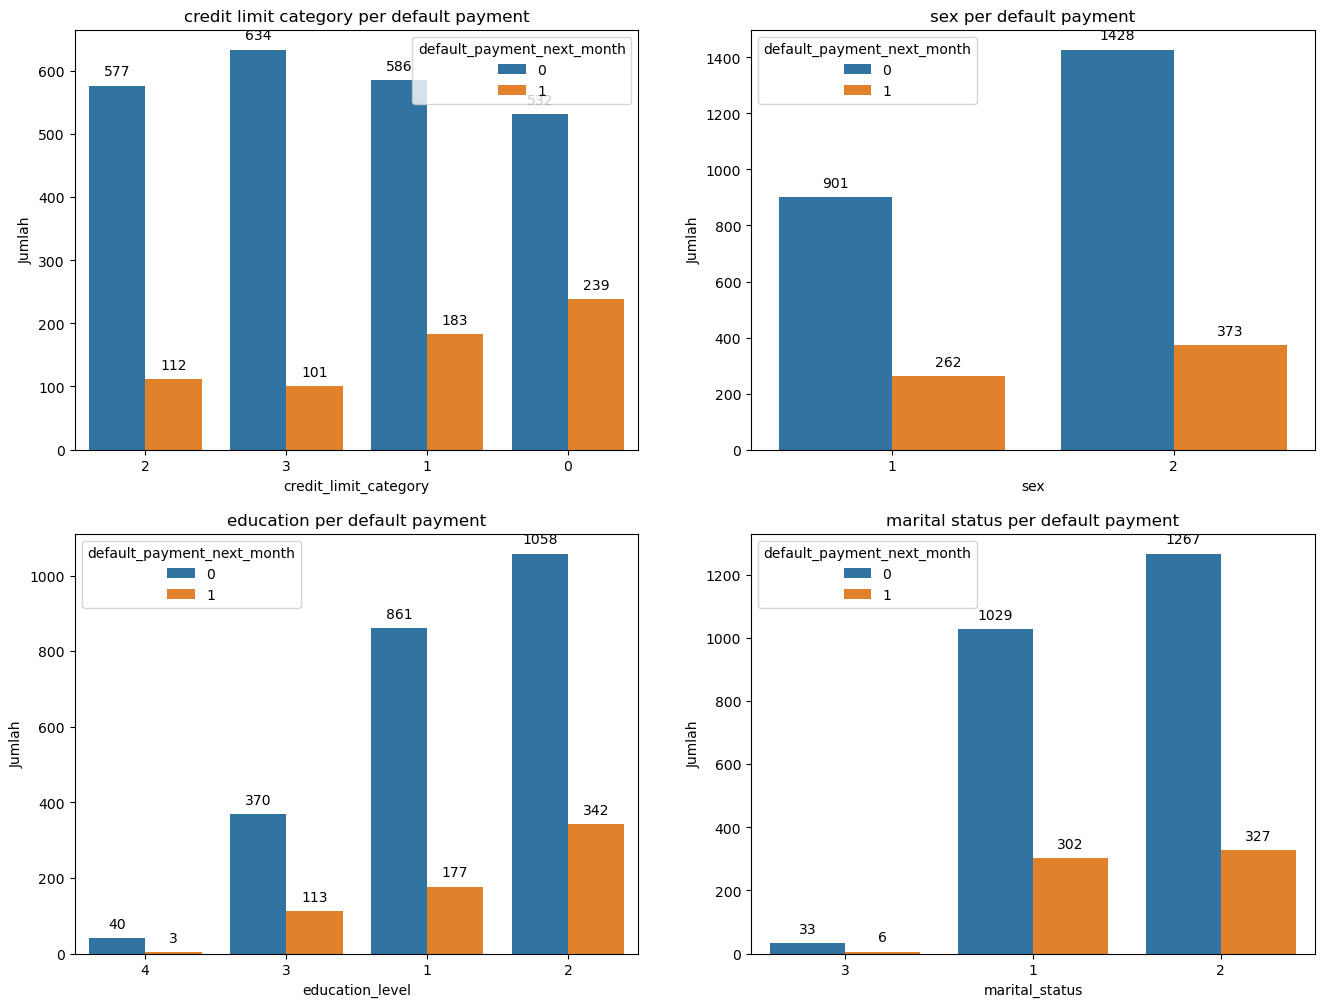

In [39]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

data_columns = ['credit_limit_category', 'sex', 'education_level', 'marital_status']
xlabels = ['credit_limit_category', 'sex', 'education_level', 'marital_status']
titles = ['credit limit category', 'sex', 'education', 'marital status']

for ax, column, xlabel, title in zip(axs.flatten(), data_columns, xlabels, titles):
    ax_plot = sns.countplot(data=df, x=column, hue='default_payment_next_month', order=df[column].value_counts(ascending=True).index, ax=ax)
    for p in ax_plot.patches:
        height = p.get_height()
        ax_plot.annotate(format(height, '.0f'), 
                              xy=(p.get_x() + p.get_width() / 2., height),
                              xytext=(0, 5),
                              textcoords='offset points',
                              ha='center',
                              va='bottom')
    ax_plot.set_title(f'{title} per default payment')
    ax_plot.set_xlabel(xlabel)
    ax_plot.set_ylabel('Jumlah')

plt.show()

Masuk pada EDA, plot diatas melihat pengguna kredit card yang akan dibekukan berdasarkan 3 kategori
1. credit_limit_category = dapat dilihat bahwa pengguna yang lancar membayar terus menerus adalah mereka yang memiliki limit balance yang besar. namun yang paling kecil adalah mereka yang memiliki limit balance terkecil serta mereka yang paling banyak yang akan di bekukan.

2. sex= dapat dilihat bahwa pengguna kredit card lebih banyak adalah perempuan dan karena populasi penggunanya lebih banyak, pengguna yang credit card nya akan di bekukan juga lebih banyak perempuan. itu bisa terjadi mungkin karena pengeluaran perempuan lebih banyak terutama untuk mereka yang harus membeli peralatan kecantikan yang tidak murah dan mungkin karena pemasukan mereka juga yang belum bisa mencukupi kebutuhan mereka.

3. marital_status = dapat dilihat bahwa pengguna kredit card lebih banyak adalah single atau belum menikah dan karena populasi penggunanya lebih banyak, pengguna yang credit card nya akan di bekukan juga lebih banyak single atau belum menikah. itu bisa terjadi mungkin karena pendapatan yang masih single masih belum stabil sehingga banyakk yang memerlukan pinjaman dan tidak mampu membayar.

4. education_level = dapat dilihat bahwa pengguna kredit card lebih banyak adalah lulusan university  dan karena populasi penggunanya lebih banyak, pengguna yang credit card nya akan di bekukan juga lebih banyak lulusan university . itu bisa terjadi mungkin karena jumlah populasi yang besar dan gaya hidup yang lumayan besar yang mengakibatkan sering melakukan pinjaman kredit dan sulit membayar.

##### Selected num to target

<AxesSubplot: xlabel='total_pay', ylabel='Count'>

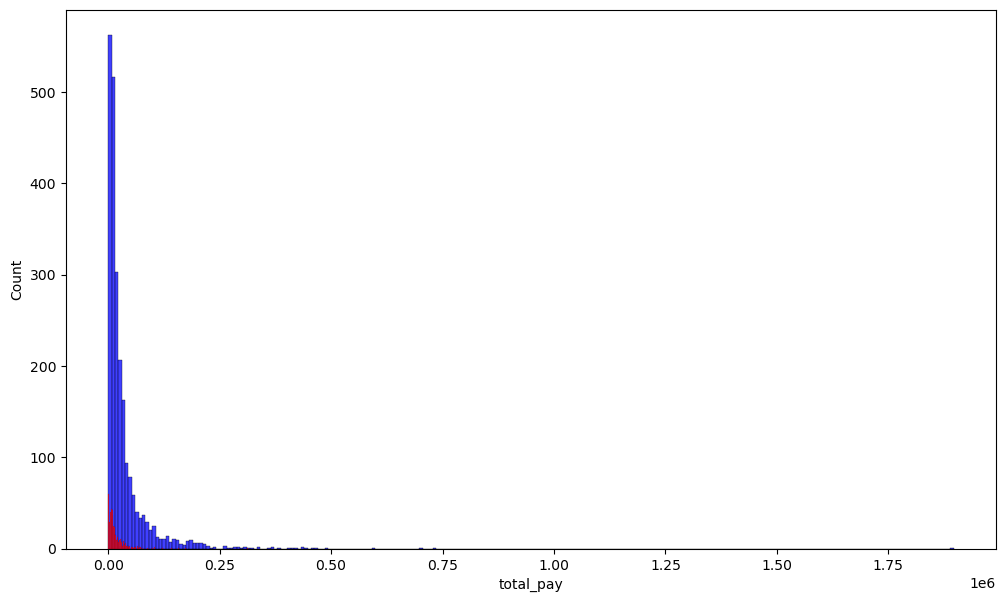

In [40]:
plt.figure(figsize=(12,7))
default_df        = df[df['default_payment_next_month'] == 1]
nodefault_df      = df[df['default_payment_next_month'] == 0]

sns.histplot(nodefault_df['total_pay'], bins = 250, color = 'b')
sns.histplot(default_df['total_pay'], bins = 250, color = 'r')

`dilihat dari plot diatas, jika semakin dikit total_pay maka akan semakin banyak juga yang akan dibekukan kartu kreditnya`

<AxesSubplot: xlabel='last_bill', ylabel='Count'>

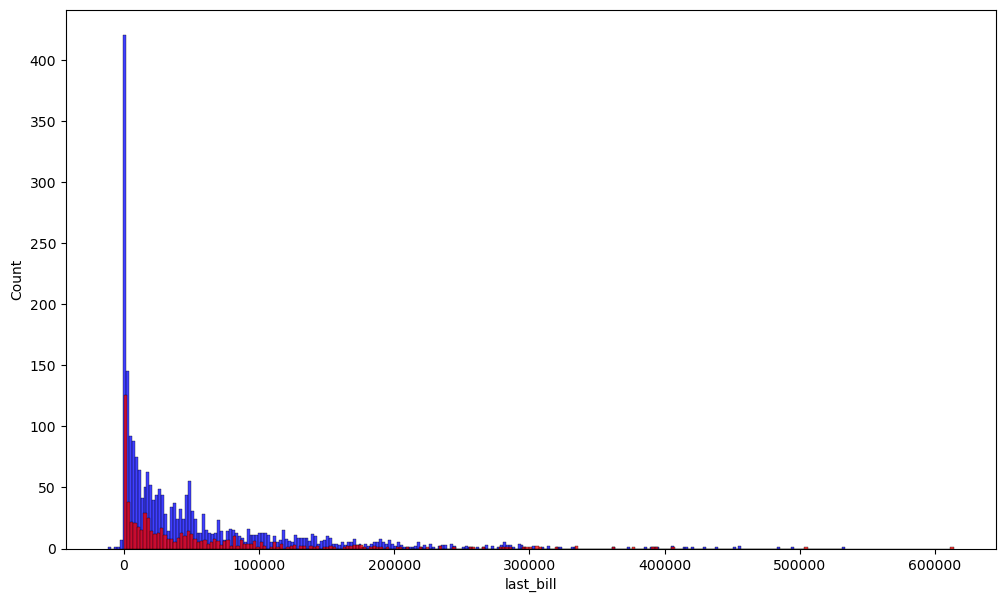

In [41]:
plt.figure(figsize=(12,7))
default_df        = df[df['default_payment_next_month'] == 1]
nodefault_df      = df[df['default_payment_next_month'] == 0]

sns.histplot(nodefault_df['last_bill'], bins = 250, color = 'b')
sns.histplot(default_df['last_bill'], bins = 250, color = 'r')

`untuk data last_bill, baik tagihan terakhir masih banyak atau sedikit tetap ada kemungkinan akan di bekukan kartu kreditnya`

<AxesSubplot: xlabel='pay_ratio', ylabel='Count'>

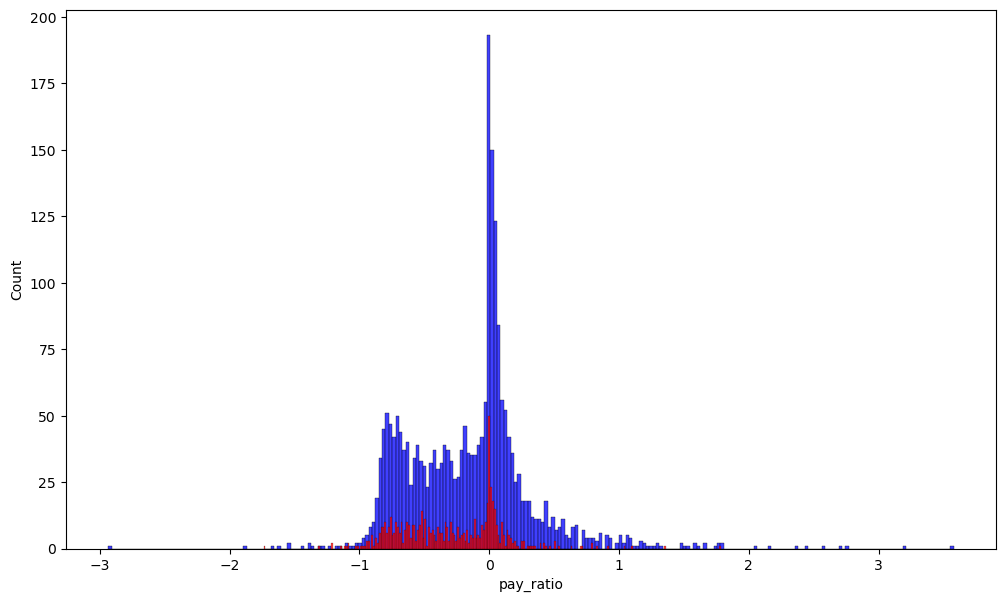

In [42]:
plt.figure(figsize=(12,7))
default_df        = df[df['default_payment_next_month'] == 1]
nodefault_df      = df[df['default_payment_next_month'] == 0]

sns.histplot(nodefault_df['pay_ratio'], bins = 250, color = 'b')
sns.histplot(default_df['pay_ratio'], bins = 250, color = 'r')

`untuk data pay_ratio, jika semakin tinggi nilai pay_ratio maka lebih bisa untuk membayar atau lunas. sehingga paling banyak dibekukan saat pay_ratio negatif`

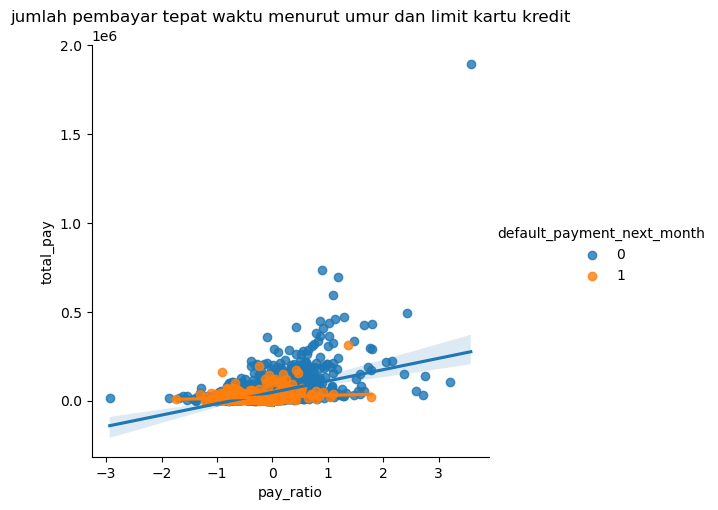

In [43]:
# ingin melihat bentuk data
sns.lmplot(x="pay_ratio", y="total_pay", hue="default_payment_next_month", data=df)

plt.title("jumlah pembayar tepat waktu menurut umur dan limit kartu kredit")

plt.show()

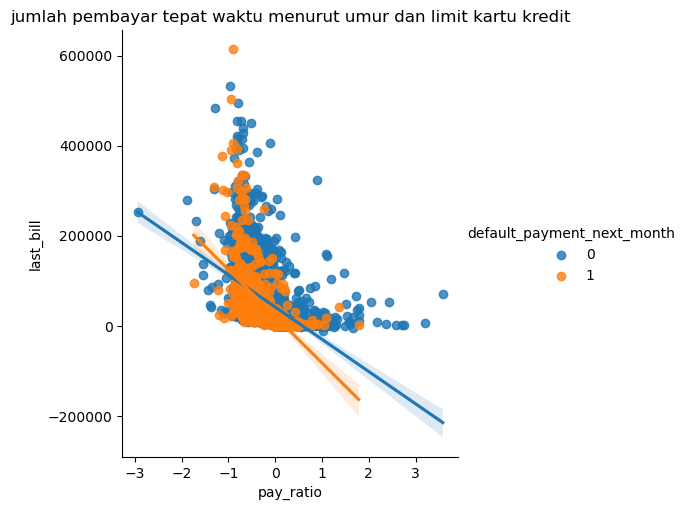

In [44]:
# ingin melihat bentuk data
sns.lmplot(x="pay_ratio", y="last_bill", hue="default_payment_next_month", data=df)

plt.title("jumlah pembayar tepat waktu menurut umur dan limit kartu kredit")

plt.show()

# Preprocessing

## Split

In [45]:
# dilakukan X dan y train and test split dengan test size 0.3
X = df[select].drop('default_payment_next_month', axis=1)
y = df['default_payment_next_month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [46]:
# ini merupakan data training X dan y train
training = pd.concat([X_train, y_train], axis=1)
training.shape

(2074, 9)

In [47]:
# ini merupakan data testing X dan y test 
testing = pd.concat([X_test, y_test], axis=1)
testing.shape

(890, 9)

In [48]:
training.head()

,credit_limit_category,total_pay,last_bill,pay_ratio,sex,education_level,marital_status,age,default_payment_next_month
1738,2,11406,39397,-0.133290,2,1,2,27,0
1103,2,131133,1499,0.762553,2,2,2,37,0
2124,2,198,2960,-0.013152,2,1,1,37,0
2211,3,120584,2594,0.235980,1,1,2,40,0
1813,0,4700,14489,-0.326300,1,1,2,35,0


In [49]:
# ini merupakan list kolom yang merupakan category dan numeric
cat= ['credit_limit_category','sex', 'education_level', 'marital_status','default_payment_next_month']
num = ['age','total_pay', 'last_bill','pay_ratio']


## Normality Test

In [50]:
stat, p = shapiro(training[num])
print('Shapiro-Wilk test statistic:', stat)
print('Shapiro-Wilk p-value:', p)

Shapiro-Wilk test statistic: 0.42127734422683716
Shapiro-Wilk p-value: 0.0


/Users/Devan/miniconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


`Berdasarkan hasil normality dengan metode Shapiro-Wilk nilai P value dibawah 0.05 yang mana dapat dikatakan data tidak terdistribusi normal secara bersama-sama atau simultan`

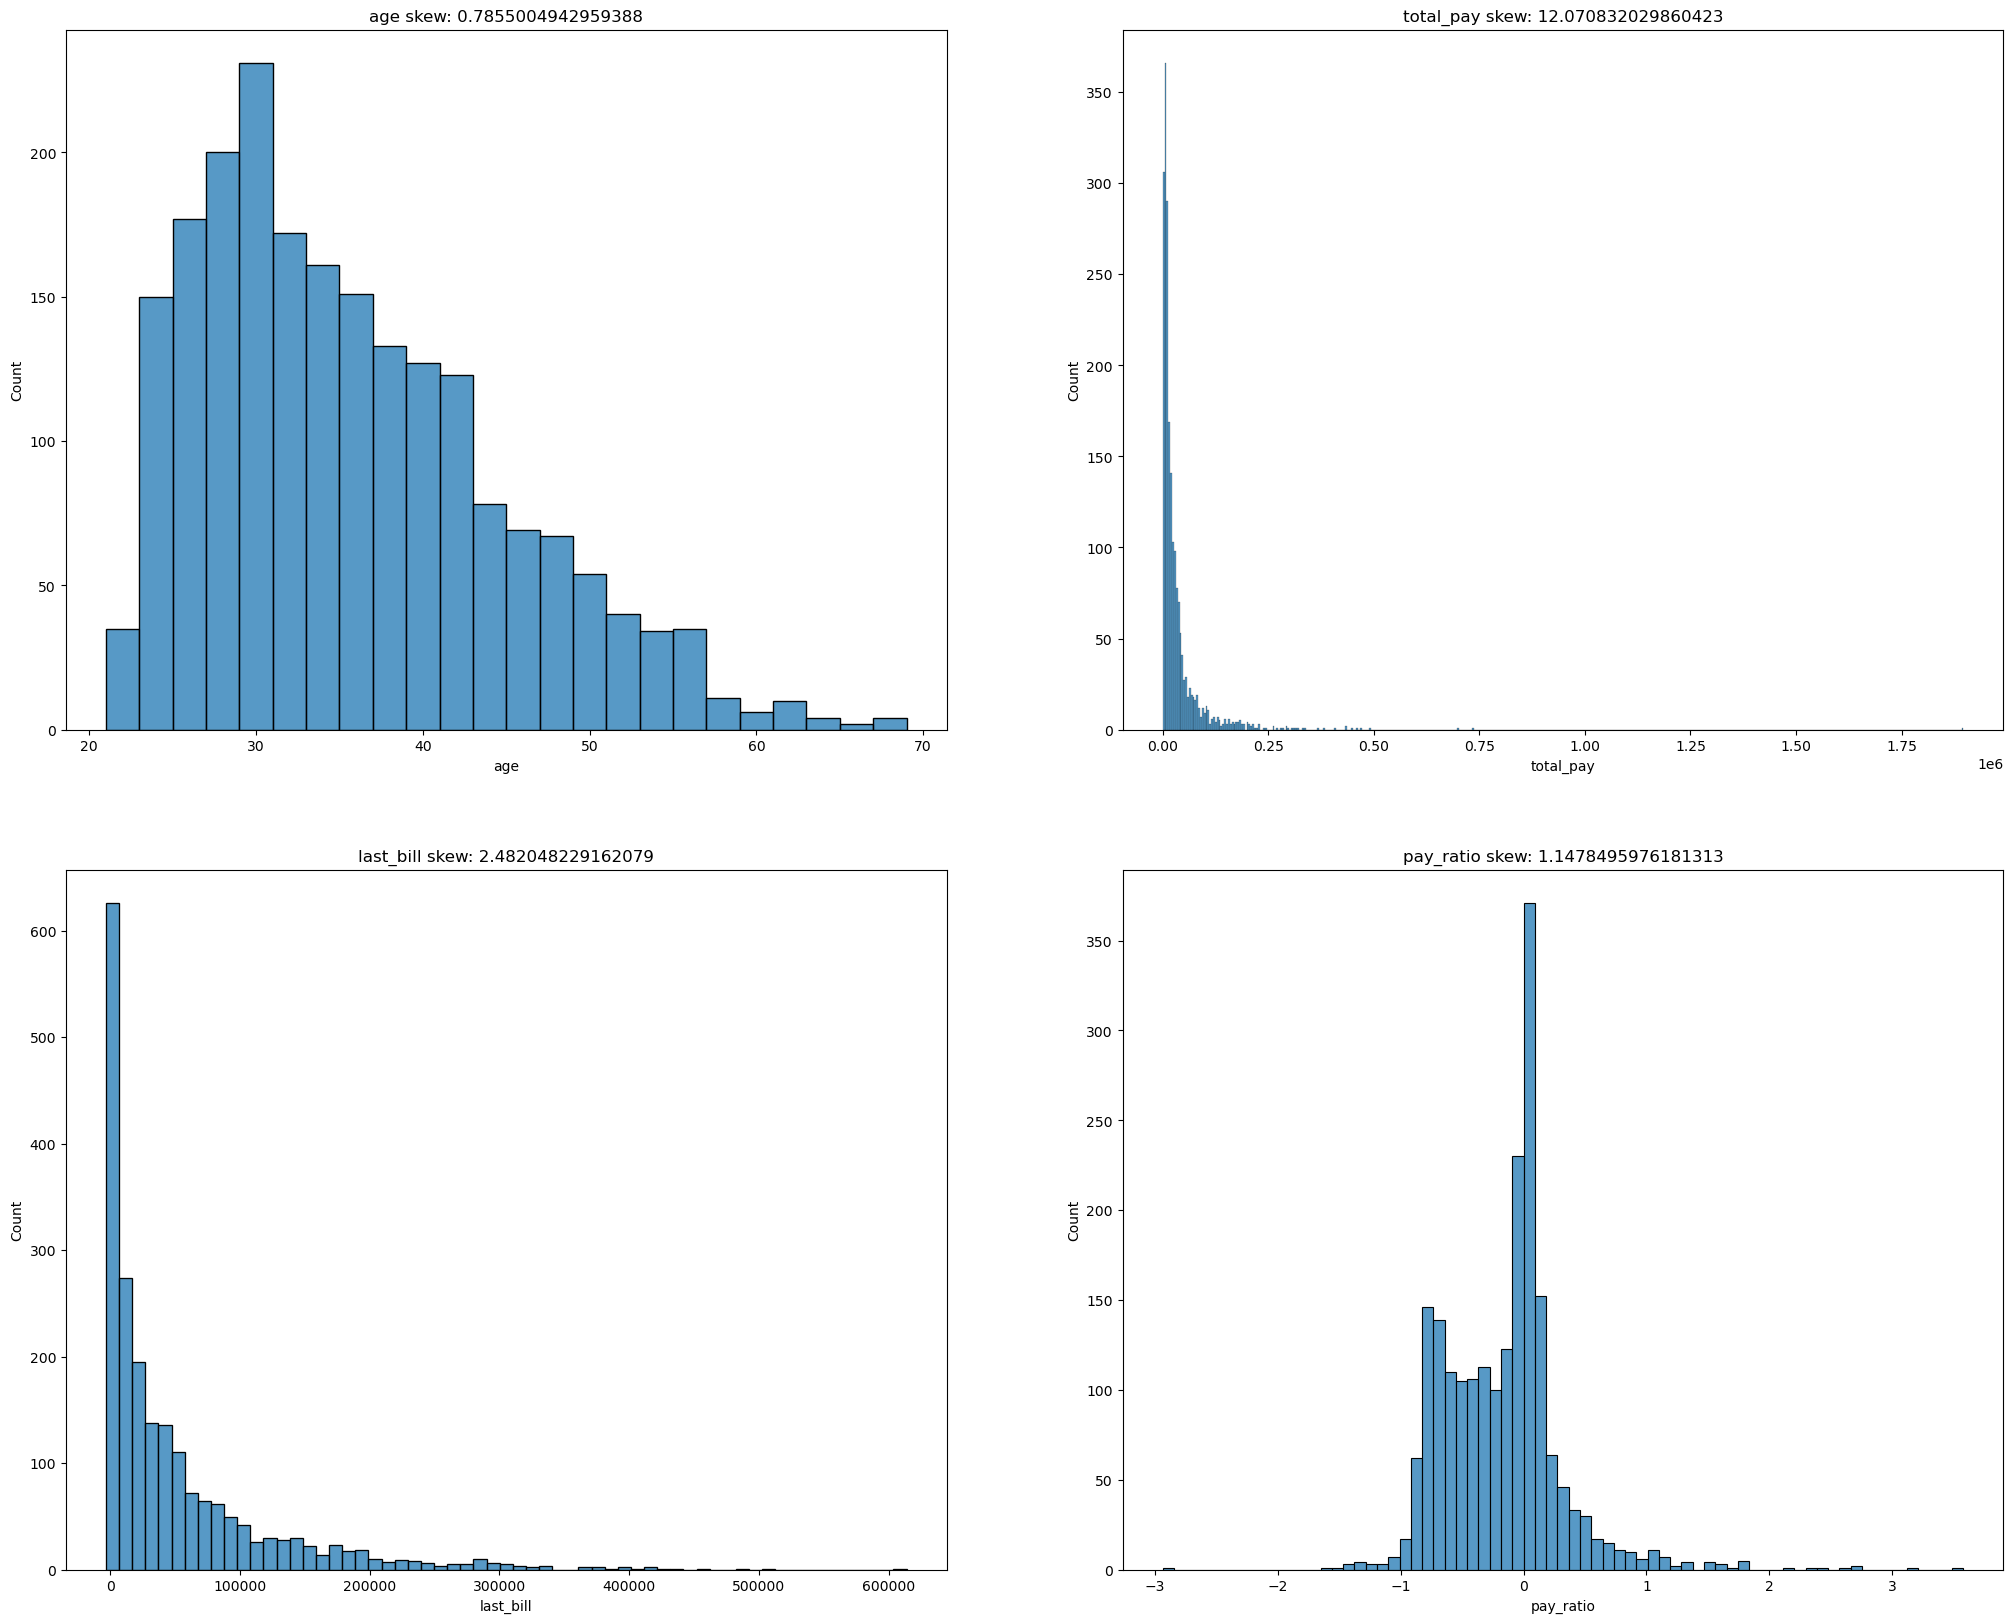

In [51]:
# Create the histogram plot
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=[25,20])
for idx, col in enumerate(num):
    sns.histplot(training[col], ax=ax[idx//2, idx%2])
    ax[idx//2, idx%2].set_title(f'{col} skew: {training[col].skew()}')
plt.show()

`Dari hasil skew dapat dilihat semua column tidak terdistribusi normal karena tidak ada yang mendekati 0 baik positif maupun negatif`

## Handling Outliers

### Handling Outliers Age

In [52]:
# outlier detection using IQR 
Q3_age = training['age'].quantile(.75)
Q1_age = training['age'].quantile(.25)

IQR = Q3_age - Q1_age

upper = Q3_age + (1.5 * IQR)
lower = Q1_age - (1.5 * IQR)

outlier_age = training['age'][(training['age'] > upper) | (training['age'] < lower)]

print('count of outlier: ', outlier_age.shape[0])
print('percentage of outlier: ', outlier_age.shape[0]/training['age'].shape[0] * 100, '%')



count of outlier:  20
percentage of outlier:  0.9643201542912248 %


`Karena data tidak terdistribusi normal, maka handling outlier menggunakan metode IQR. `

`Karena jumlah outliers tidak sampai 1% maka data akan di trimming`

In [53]:
training.drop(list(outlier_age.index),inplace=True)

In [54]:
# outlier detection using IQR 
Q3_age = training['age'].quantile(.75)
Q1_age = training['age'].quantile(.25)

IQR = Q3_age - Q1_age

upper = Q3_age + (1.5 * IQR)
lower = Q1_age - (1.5 * IQR)

outlier_age = training['age'][(training['age'] > upper) | (training['age'] < lower)]

print('count of outlier: ', outlier_age.shape[0])
print('percentage of outlier: ', outlier_age.shape[0]/training['age'].shape[0] * 100, '%')


count of outlier:  0
percentage of outlier:  0.0 %


### Handling Outliers Total Pay

In [55]:
# outlier detection using IQR 
Q3_total_pay = training['total_pay'].quantile(.75)
Q1_total_pay = training['total_pay'].quantile(.25)

IQR = Q3_total_pay - Q1_total_pay

upper = Q3_total_pay + (3 * IQR)
lower = Q1_total_pay - (3 * IQR)

outlier_total_pay = training['total_pay'][(training['total_pay'] > upper) | (training['total_pay'] < lower)]

print('count of outlier: ', outlier_total_pay.shape[0])
print('percenttotal_pay of outlier: ', outlier_total_pay.shape[0]/training['total_pay'].shape[0] * 100, '%')



count of outlier:  117
percenttotal_pay of outlier:  5.69620253164557 %


`Karena data tidak terdistribusi normal, maka handling outlier menggunakan metode IQR. `

`Karena jumlah outliers sangat besar, maka akan dilakukan capping`

In [56]:
wins = Winsorizer(capping_method='iqr', tail='both', fold=3, variables=['total_pay'])

training['total_pay'] = wins.fit_transform(training[['total_pay']])

In [57]:
# outlier detection using IQR 
Q3_total_pay = training['total_pay'].quantile(.75)
Q1_total_pay = training['total_pay'].quantile(.25)

IQR = Q3_total_pay - Q1_total_pay

upper = Q3_total_pay + (3 * IQR)
lower = Q1_total_pay - (3 * IQR)

outlier_total_pay = training['total_pay'][(training['total_pay'] > upper) | (training['total_pay'] < lower)]

print('count of outlier: ', outlier_total_pay.shape[0])
print('percenttotal_pay of outlier: ', outlier_total_pay.shape[0]/training['total_pay'].shape[0] * 100, '%')



count of outlier:  0
percenttotal_pay of outlier:  0.0 %


### Handling Outliers Last Bill

In [58]:
# outlier detection using IQR 
Q3_last_bill = training['last_bill'].quantile(.75)
Q1_last_bill = training['last_bill'].quantile(.25)

IQR = Q3_last_bill - Q1_last_bill

upper = Q3_last_bill + (3 * IQR)
lower = Q1_last_bill - (3 * IQR)

outlier_last_bill = training['last_bill'][(training['last_bill'] > upper) | (training['last_bill'] < lower)]

print('count of outlier: ', outlier_last_bill.shape[0])
print('percentlast_bill of outlier: ', outlier_last_bill.shape[0]/training['last_bill'].shape[0] * 100, '%')



count of outlier:  55
percentlast_bill of outlier:  2.677702044790652 %


`Karena data tidak terdistribusi normal, maka handling outlier menggunakan metode IQR. `

`Karena jumlah outliers sangat besar, maka akan dilakukan capping`

In [59]:
wins = Winsorizer(capping_method='iqr', tail='both', fold=3, variables=['last_bill'])

training['last_bill'] = wins.fit_transform(training[['last_bill']])

In [60]:
# outlier detection using IQR 
Q3_last_bill = training['last_bill'].quantile(.75)
Q1_last_bill = training['last_bill'].quantile(.25)

IQR = Q3_last_bill - Q1_last_bill

upper = Q3_last_bill + (3 * IQR)
lower = Q1_last_bill - (3 * IQR)

outlier_last_bill = training['last_bill'][(training['last_bill'] > upper) | (training['last_bill'] < lower)]

print('count of outlier: ', outlier_last_bill.shape[0])
print('percentlast_bill of outlier: ', outlier_last_bill.shape[0]/training['last_bill'].shape[0] * 100, '%')



count of outlier:  0
percentlast_bill of outlier:  0.0 %


### Handling Outliers Pay Ratio

In [61]:
# outlier detection using IQR 
Q3_pay_ratio = training['pay_ratio'].quantile(.75)
Q1_pay_ratio = training['pay_ratio'].quantile(.25)

IQR = Q3_pay_ratio - Q1_pay_ratio

upper = Q3_pay_ratio + (1.5 * IQR)
lower = Q1_pay_ratio - (1.5 * IQR)

outlier_pay_ratio = training['pay_ratio'][(training['pay_ratio'] > upper) | (training['pay_ratio'] < lower)]

print('count of outlier: ', outlier_pay_ratio.shape[0])
print('percentpay_ratio of outlier: ', outlier_pay_ratio.shape[0]/training['pay_ratio'].shape[0] * 100, '%')



count of outlier:  52
percentpay_ratio of outlier:  2.5316455696202533 %


`Karena data tidak terdistribusi normal, maka handling outlier menggunakan metode IQR. `

`Karena jumlah outliers sangat besar, maka akan dilakukan capping`

In [62]:
wins = Winsorizer(capping_method='iqr', tail='both', fold=3, variables=['pay_ratio'])

training['pay_ratio'] = wins.fit_transform(training[['pay_ratio']])

In [63]:
# outlier detection using IQR 
Q3_pay_ratio = training['pay_ratio'].quantile(.75)
Q1_pay_ratio = training['pay_ratio'].quantile(.25)

IQR = Q3_pay_ratio - Q1_pay_ratio

upper = Q3_pay_ratio + (1.5 * IQR)
lower = Q1_pay_ratio - (1.5 * IQR)

outlier_pay_ratio = training['pay_ratio'][(training['pay_ratio'] > upper) | (training['pay_ratio'] < lower)]

print('count of outlier: ', outlier_pay_ratio.shape[0])
print('percentpay_ratio of outlier: ', outlier_pay_ratio.shape[0]/training['pay_ratio'].shape[0] * 100, '%')



count of outlier:  52
percentpay_ratio of outlier:  2.5316455696202533 %


### Spliting training and testing

`Karena handling outlier menggunakan data training, maka X dan y perlu dipisahkan kembali`

In [64]:
#training
X_train = training.drop('default_payment_next_month', axis=1)
y_train = training['default_payment_next_month']

# Testing
X_test = testing.drop('default_payment_next_month', axis=1)
y_test = testing['default_payment_next_month']

### Pendefinisian scaling dan modeling untuk pipeline

In [65]:
# Scaler
numeric_features= ['age', 'total_pay', 'last_bill', 'pay_ratio', 'credit_limit_category', 'sex', 'education_level', 'marital_status']
numeric_transformer= MinMaxScaler() 

In [66]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scal', numeric_transformer, numeric_features)
    ])

In [67]:
pip_logreg= Pipeline(
    steps= [("preprocessor", preprocessor),  ("classifier", LogisticRegression())]
)

pip_dt= Pipeline(
    steps= [("preprocessor", preprocessor),  ("classifier", DecisionTreeClassifier())]
)

pip_SVM= Pipeline(
    steps= [("preprocessor", preprocessor),  ("classifier", SVC())]
)

pip_rf= Pipeline(
    steps= [("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)

pip_nb= Pipeline(
    steps= [("preprocessor", preprocessor), ("classifier", GaussianNB())]
)

pip_knn= Pipeline(
    steps= [("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())]
)

pip_ada= Pipeline(
    steps= [("preprocessor", preprocessor), ("classifier", AdaBoostClassifier())]
)


# Modeling

### Logistic Regression

In [68]:
logreg_params = [{ 'classifier__penalty': ['l1', 'l2', 'elasticnet'],
                'classifier__C': [0.1, 1.0, 10.0],
                'classifier__solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag'],
                'classifier__max_iter': [100, 500, 1000]}]
# create the grid search object
grid_search = GridSearchCV(pip_logreg, logreg_params, cv=5, scoring='recall', return_train_score=True)

# fit the grid search object to the training data
grid_search.fit(X_train, y_train)


# print the best hyperparameters and test score
print("Best parameters: ", grid_search.best_params_)
print("Test recall train: ", grid_search.score(X_train, y_train))
print("Test recall test: ", grid_search.score(X_test, y_test))


Best parameters:  {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Test recall train:  0.0
Test recall test:  0.0


/Users/Devan/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
315 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Devan/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Devan/miniconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/Devan/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _ch

In [69]:
cv_scores_logreg = grid_search.cv_results_['mean_test_score']
cv_std_logreg = grid_search.cv_results_['std_test_score']

print("mean_test_score: ", cv_scores_logreg.mean())
print("std_test_score: ", cv_std_logreg.mean())

mean_test_score:  nan
std_test_score:  nan


Nilai rata-rata cross validation dan std nan, karena nilai dari predict menggunakan model logistic regression hasilnya kebanyakan nilai 0 dan Nan. karena:

- Imbalanced data: Jika dataset yang digunakan untuk pelatihan model Logistic Regression tidak seimbang (imbalanced), artinya jumlah sampel pada kelas positif dan negatif tidak seimbang, maka model dapat memprediksi kebanyakan pada kelas mayoritas dan menghasilkan banyak nilai 0 pada kelas minoritas. Selain itu, jika data pada kelas minoritas terlalu sedikit, model mungkin tidak dapat mempelajari pola yang tepat dan menghasilkan banyak nilai NaN.

- Overfitting: Jika model Logistic Regression terlalu kompleks dan terlalu cocok dengan data pelatihan, maka dapat terjadi overfitting. Hal ini dapat menghasilkan hasil prediksi yang buruk pada data pengujian dan menghasilkan banyak nilai 0 atau NaN.

- Variabel tidak relevan: Jika variabel yang digunakan tidak relevan atau tidak memberikan informasi yang cukup pada variabel target, maka model dapat menghasilkan prediksi yang buruk dan menghasilkan banyak nilai 0 atau NaN.

In [70]:
# get the best estimator from the grid search
best_logreg = grid_search.best_estimator_.named_steps['classifier']

# get the coefficients of the logistic regression model
coef = best_logreg.coef_

# print the coefficients
print('coefficients: ', coef)


coefficients:  [[ 0.         -1.20454772  0.         -0.7579302  -0.54152331  0.
   0.         -0.31046381]]


`Hal diatas tersebut, berpengaruh terhadap nilai coefficientsnya yang mana banyak nilai 0 atau tidak memiliki pengaruh terhadap target`

In [71]:
# predict on the training data using the best model found by grid search
y_pred_train_logreg = grid_search.predict(X_train)

# predict on the test data using the best model found by grid search
y_pred_test_logreg = grid_search.predict(X_test)

In [72]:
auc_train = roc_auc_score(y_train, y_pred_train_logreg)
auc_test = roc_auc_score(y_test, y_pred_test_logreg)
print(f"AUC Train: {auc_train}" )
print(f"AUC score Test: {auc_test}")

AUC Train: 0.5
AUC score Test: 0.5


In [73]:
# Membandingkat nilai logistic train dan tes
#Classification Report Train
print('`Train Classification Report, Logistic Regression`')
print(classification_report(y_train, y_pred_train_logreg))
print('Precision : ', precision_score(y_train, y_pred_train_logreg))
print('Recall    : ', recall_score(y_train, y_pred_train_logreg))

print(" ")
print(" ") # untuk enter
print(" ")

# Classification Report Test
print('`Test Classification Report, Logistic Regression`')
print(classification_report(y_test, y_pred_test_logreg))
print('Precision : ', precision_score(y_test, y_pred_test_logreg))
print('Recall    : ', recall_score(y_test, y_pred_test_logreg))

`Train Classification Report, Logistic Regression`
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1609
           1       0.00      0.00      0.00       445

    accuracy                           0.78      2054
   macro avg       0.39      0.50      0.44      2054
weighted avg       0.61      0.78      0.69      2054

Precision :  0.0
Recall    :  0.0
 
 
 
`Test Classification Report, Logistic Regression`
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       705
           1       0.00      0.00      0.00       185

    accuracy                           0.79       890
   macro avg       0.40      0.50      0.44       890
weighted avg       0.63      0.79      0.70       890

Precision :  0.0
Recall    :  0.0


/Users/Devan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Devan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Devan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Devan/miniconda3/lib/

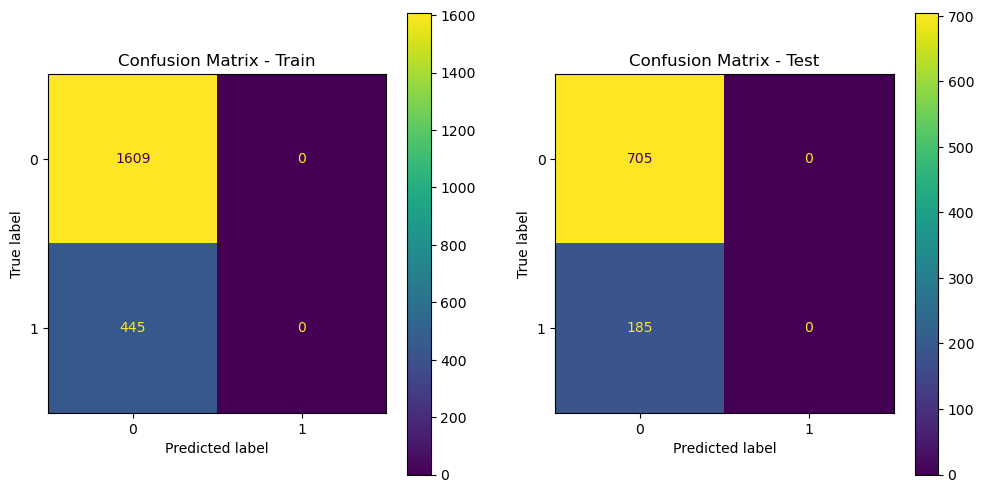

In [74]:
# membuat subplots dengan ukuran 12x6
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# menampilkan confusion matrix train pada subplot pertama
disp_train = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_pred_train_logreg))
disp_train.plot(ax=ax[0], values_format='d')
ax[0].set_title('Confusion Matrix - Train')

# menampilkan confusion matrix test pada subplot kedua
disp_test = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, y_pred_test_logreg))
disp_test.plot(ax=ax[1], values_format='d')
ax[1].set_title('Confusion Matrix - Test')

# menampilkan plot
plt.show()

####  Conclusion Logistic regression


performa model Logistic Regression pada data training dan data testing untuk memprediksi kelas minoritas (1).

Dari Train Classification Report, dapat dilihat bahwa model memiliki nilai precision dan recall yang sangat rendah (0.0) untuk kelas minoritas (1), artinya model tidak mampu memprediksi dengan baik kelas minoritas.

Dari Test Classification Report, dapat dilihat bahwa hasilnya sama dengan Train Classification Report, yaitu model memiliki nilai precision dan recall yang sangat rendah (0.0) untuk kelas minoritas (1), artinya model tidak mampu memprediksi dengan baik kelas minoritas pada data testing.

Hal ini menunjukkan bahwa model Logistic Regression tidak cocok untuk memprediksi kelas minoritas pada dataset yang tidak seimbang (imbalanced dataset).

### Decision Tree

In [75]:
dt_params = {'classifier__criterion': ['gini', 'entropy'], 
             'classifier__max_depth': [5, 10, 15, 20, None],
             'classifier__min_samples_split': [2, 5, 10, 15]}
# create the grid search object
grid_search_dt = GridSearchCV(pip_dt, dt_params, cv=5, scoring='recall', return_train_score=True)

# fit the grid search object to the training data
grid_search_dt.fit(X_train, y_train)

# print the best hyperparameters and test score
print("Best parameters: ", grid_search_dt.best_params_)
print("Test recall train: ", grid_search_dt.score(X_train, y_train))
print("Test recall test: ", grid_search_dt.score(X_test, y_test))

Best parameters:  {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_split': 2}
Test recall train:  0.9977528089887641
Test recall test:  0.2648648648648649


dengan menggunakan grid_search untuk menentukan hyperparameter terbaik untuk model ini, ditemukan hyperparameternya adalah: {`'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_split': 2}`

- Dengan Nilai Recall data Train = 0.9977528089887641
- Dengan Nilai Recall data Test = 0.2756756756756757

nilai recall sebesar 0.28. Recall mengukur seberapa banyak kasus positif yang dapat diprediksi dengan benar oleh model. Hasil ini menunjukkan bahwa model dapat memprediksi sekitar 28% kasus positif dengan benar pada data test. Namun, performa model pada data train relatif lebih tinggi, dengan nilai recall sebesar 0.99, yang menunjukkan kemungkinan terjadinya overfitting pada model.


#### Conceptual Problems

1. Apa yang dimaksud dengan criterion pada Decision Tree ? Jelaskan criterion yang kalian pakai dalam kasus ini !

- Criterion pada Decision Tree adalah metode yang digunakan untuk mengukur kualitas pembagian (split) node pada pohon keputusan. Pilihan criterion sangat penting karena akan mempengaruhi bagaimana Decision Tree membangun model prediksi.

Dalam kasus ini, criterion yang dipilih adalah 'gini', yang merupakan salah satu dari dua criterion yang umum digunakan dalam Decision Tree, selain entropy. Gini impurity adalah suatu pengukuran yang digunakan untuk mengukur kualitas split node dengan menghitung seberapa campur atau tidak campur (impure) kelas target pada setiap node. Semakin kecil nilai gini impurity, semakin baik kualitas pembagian node tersebut.

In [76]:
cv_scores_dt = grid_search_dt.cv_results_['mean_test_score']
cv_std_dt = grid_search_dt.cv_results_['std_test_score']

print("mean_test_score: ", cv_scores_dt.mean())
print("std_test_score: ", cv_std_dt.mean())

mean_test_score:  0.18595505617977529
std_test_score:  0.044996476798114304


- mean_test_score adalah rata-rata skor pengujian dari model pada seluruh iterasi cross-validation yang dilakukan. Dalam kasus ini, nilai rata-rata skor pengujian adalah 0.18724719101123594.

- std_test_score adalah simpangan baku dari skor pengujian dari model pada seluruh iterasi cross-validation yang dilakukan. Simpangan baku mengukur seberapa jauh nilai-nilai pengujian tersebar dari nilai rata-ratanya. Dalam kasus ini, nilai simpangan bakunya adalah 0.04513248197741944.

In [77]:
# get the best estimator
best_dt = grid_search_dt.best_estimator_

# get the feature importances
importances = best_dt.named_steps['classifier'].feature_importances_

# print the coefficients
for feature, importance in zip(X_train.columns, importances):
    print(f'{feature}: {importance:.3f}')

credit_limit_category: 0.141
total_pay: 0.275
last_bill: 0.173
pay_ratio: 0.283
sex: 0.026
education_level: 0.031
marital_status: 0.036
age: 0.036


Diatas merupakan nilai coef yang menggunakan feature_importances

dari hasil yang ada dapat dilihat bahwa feature yang memiliki pengaruh terbesar kenapa pengguna kartu kredit dapat di bekukan adalah:
- credit_limit_category: 0.154
- total_pay: 0.263
- last_bill: 0.198
- pay_ratio: 0.245
yang mana merupakan nilai-nilai yang berkaitan erat dengan kredit score.

In [78]:
# predict on the training data using the best model found by grid search
y_pred_train_dt = grid_search_dt.predict(X_train)

# predict on the test data using the best model found by grid search
y_pred_test_dt = grid_search_dt.predict(X_test)

In [79]:
auc_train = roc_auc_score(y_train, y_pred_train_dt)
auc_test = roc_auc_score(y_test, y_pred_test_dt)
print(f"AUC Train DT: {auc_train}" )
print(f"AUC score Test DT: {auc_test}")

AUC Train DT: 0.9988764044943821
AUC score Test DT: 0.5288863331416522


In [80]:
# Membandingkat nilai logistic train dan tes
#Classification Report Train
print('`Train Classification Report, Decision Tree`')
print(classification_report(y_train, y_pred_train_dt))
print('Precision : ', precision_score(y_train, y_pred_train_dt))
print('Recall    : ', recall_score(y_train, y_pred_train_dt))

print(" ")
print(" ") # untuk enter
print(" ")

# Classification Report Test
print('`Test Classification Report, Decision Tree`')
print(classification_report(y_test, y_pred_test_dt))
print('Precision : ', precision_score(y_test, y_pred_test_dt))
print('Recall    : ', recall_score(y_test, y_pred_test_dt))

`Train Classification Report, Decision Tree`
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1609
           1       1.00      1.00      1.00       445

    accuracy                           1.00      2054
   macro avg       1.00      1.00      1.00      2054
weighted avg       1.00      1.00      1.00      2054

Precision :  1.0
Recall    :  0.9977528089887641
 
 
 
`Test Classification Report, Decision Tree`
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       705
           1       0.25      0.26      0.26       185

    accuracy                           0.68       890
   macro avg       0.53      0.53      0.53       890
weighted avg       0.69      0.68      0.69       890

Precision :  0.2512820512820513
Recall    :  0.2648648648648649


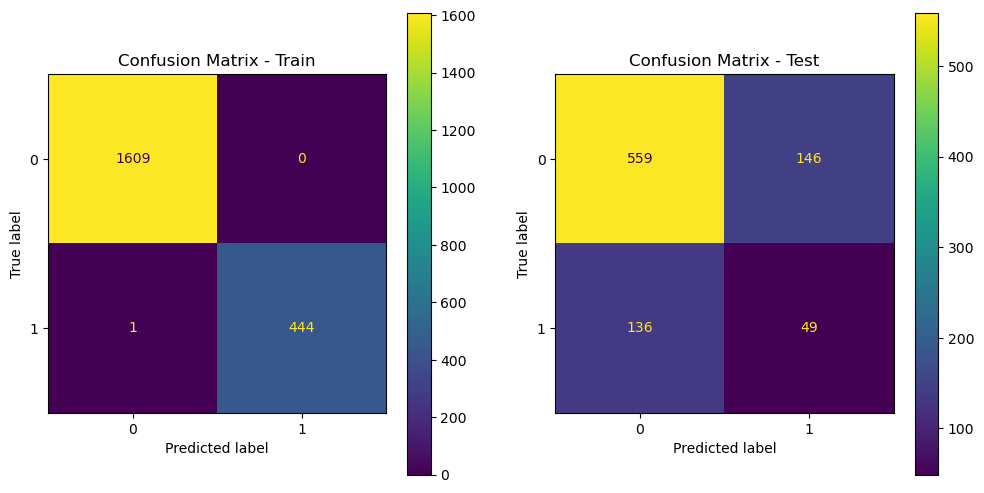

In [81]:
# membuat subplots dengan ukuran 12x6
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# menampilkan confusion matrix train pada subplot pertama
disp_train = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_pred_train_dt))
disp_train.plot(ax=ax[0], values_format='d')
ax[0].set_title('Confusion Matrix - Train')

# menampilkan confusion matrix test pada subplot kedua
disp_test = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, y_pred_test_dt))
disp_test.plot(ax=ax[1], values_format='d')
ax[1].set_title('Confusion Matrix - Test')

# menampilkan plot
plt.show()

#### Conclusion Decision Tree

performa model Decision Tree pada data training dan data testing untuk memprediksi kelas minoritas (1).

- Pada data training, terdapat 2 kelas yaitu kelas 0 dan kelas 1. Dari laporan tersebut, dapat diinterpretasikan bahwa pada kelas 0 dan kelas 1, model memiliki nilai precision, recall, dan f1-score sebesar 1.00 atau 100%. Artinya, model mampu memprediksi dengan sempurna untuk kedua kelas tersebut. Namun, nilai recall untuk kelas 1 adalah 0.99775 atau sekitar 99.8%, artinya terdapat sebagian kecil data kelas 1 yang tidak terdeteksi oleh model.

- Sedangkan pada data testing, terdapat kelas 0 dan kelas 1 dengan jumlah support masing-masing 705 dan 185. Dari laporan tersebut, dapat dilihat bahwa model memiliki nilai precision sebesar 0.244 atau sekitar 24.4% dan recall sebesar 0.276 atau sekitar 27.6% pada kelas 1. Artinya, model hanya dapat memprediksi kelas 1 dengan tingkat akurasi yang rendah, dan model cenderung mengklasifikasikan data sebagai kelas 0.

Terdapat indikasi bahwa model yang dilaporkan sedang mengalami overfitting, karena pada train classification report nilai precision dan recall pada kelas 1 (minority class) adalah 1.0, sedangkan pada test classification report nilai precision dan recall pada kelas 1 hanya sekitar 0.24 dan 0.28. Selisih nilai ini menunjukkan bahwa model cukup baik dalam mempelajari data train, tetapi kurang mampu dalam melakukan generalisasi pada data test yang belum pernah dilihat sebelumnya. Selain itu, perbedaan yang cukup besar antara nilai akurasi pada train (1.0) dan test (0.67) juga menunjukkan indikasi overfitting.

### SVM

In [82]:
svm_params = [{'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf', 'poly'],
            'classifier__gamma': ['scale', 'auto'],
            'classifier__degree': [2, 3, 4]}]

# create the grid search object
grid_search_svm = GridSearchCV(pip_SVM, svm_params, cv=5, scoring='recall', return_train_score=True)

# fit the grid search object to the training data
grid_search_svm.fit(X_train, y_train)

# print the best hyperparameters and test score
print("Best parameters: ", grid_search_svm.best_params_)
print("Test recall train: ", grid_search_svm.score(X_train, y_train))
print("Test recall test: ", grid_search_svm.score(X_test, y_test))

Best parameters:  {'classifier__C': 10, 'classifier__degree': 4, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}
Test recall train:  0.04044943820224719
Test recall test:  0.02702702702702703


dengan menggunakan grid_search untuk menentukan hyperparameter terbaik untuk model ini, ditemukan hyperparameternya adalah: `{'classifier__C': 10, 'classifier__degree': 4, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}`

- Dengan Nilai Recall data Train = 0.04044943820224719
- Dengan Nilai Recall data Test = 0.02702702702702703

hasil evaluasi model pada data train menunjukkan recall sebesar 0.0404 atau 4.04%, sedangkan hasil evaluasi model pada data test menunjukkan recall sebesar 0.0270 atau 2.70%. Recall pada model ini menunjukkan kemampuan model dalam mengenali jumlah true positives dari keseluruhan nilai positif pada dataset. Oleh karena itu, hasil yang rendah pada recall menunjukkan kinerja model yang buruk dalam mengenali data positif, terutama pada data test.


In [83]:
cv_scores_svm = grid_search_svm.cv_results_['mean_test_score']
cv_std_svm = grid_search_svm.cv_results_['std_test_score']

print("mean_test_score: ", cv_scores_svm.mean())
print("std_test_score: ", cv_std_svm.mean())

mean_test_score:  0.0004993757802746567
std_test_score:  0.0004993757802746567


- mean_test_score adalah rata-rata skor pengujian dari model pada seluruh iterasi cross-validation yang dilakukan. Dalam kasus ini, nilai rata-rata skor pengujian adalah 0.0004993757802746567

- std_test_score adalah simpangan baku dari skor pengujian dari model pada seluruh iterasi cross-validation yang dilakukan. Simpangan baku mengukur seberapa jauh nilai-nilai pengujian tersebar dari nilai rata-ratanya. Dalam kasus ini, nilai simpangan bakunya adalah 0.0004993757802746567

In [84]:
# predict on the training data using the best model found by grid search
y_pred_train_svm = grid_search_svm.predict(X_train)

# predict on the test data using the best model found by grid search
y_pred_test_svm = grid_search_svm.predict(X_test)

In [85]:
auc_train = roc_auc_score(y_train, y_pred_train_svm)
auc_test = roc_auc_score(y_test, y_pred_test_svm)
print(f"AUC Train svm: {auc_train}" )
print(f"AUC score Test svm: {auc_test}")

AUC Train svm: 0.5199139670812355
AUC score Test svm: 0.5014567759248609


In [86]:
# Membandingkat nilai logistic train dan tes
#Classification Report Train
print('`Train Classification Report, SVM`')
print(classification_report(y_train, y_pred_train_svm))
print('Precision : ', precision_score(y_train, y_pred_train_svm))
print('Recall    : ', recall_score(y_train, y_pred_train_svm))

print(" ")
print(" ") # untuk enter
print(" ")

# Classification Report Test
print('`Test Classification Report, SVM`')
print(classification_report(y_test, y_pred_test_svm))
print('Precision : ', precision_score(y_test, y_pred_test_svm))
print('Recall    : ', recall_score(y_test, y_pred_test_svm))

`Train Classification Report, SVM`
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1609
           1       0.95      0.04      0.08       445

    accuracy                           0.79      2054
   macro avg       0.87      0.52      0.48      2054
weighted avg       0.82      0.79      0.71      2054

Precision :  0.9473684210526315
Recall    :  0.04044943820224719
 
 
 
`Test Classification Report, SVM`
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       705
           1       0.23      0.03      0.05       185

    accuracy                           0.78       890
   macro avg       0.51      0.50      0.46       890
weighted avg       0.68      0.78      0.70       890

Precision :  0.22727272727272727
Recall    :  0.02702702702702703


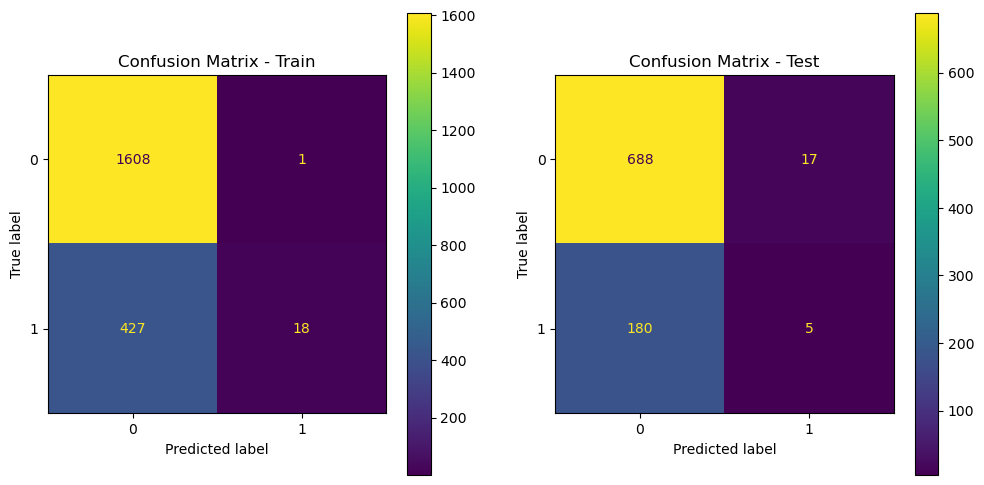

In [87]:
# membuat subplots dengan ukuran 12x6
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# menampilkan confusion matrix train pada subplot pertama
disp_train = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_pred_train_svm))
disp_train.plot(ax=ax[0], values_format='d')
ax[0].set_title('Confusion Matrix - Train')

# menampilkan confusion matrix test pada subplot kedua
disp_test = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, y_pred_test_svm))
disp_test.plot(ax=ax[1], values_format='d')
ax[1].set_title('Confusion Matrix - Test')

# menampilkan plot
plt.show()

#### Conclusion SVM

performa model SVM pada data training dan data testing untuk memprediksi kelas minoritas (1).

- Pada data train, model memiliki nilai precision yang cukup tinggi yaitu 0.9473. Namun, recall pada data train cukup rendah hanya sebesar 0.0404, yang mengindikasikan model kurang mampu dalam mengidentifikasi kelas minoritas.

- Pada data test, model memiliki nilai precision yang rendah yaitu hanya 0.2273, yang artinya dari seluruh hasil prediksi yang benar, hanya 22.7% di antaranya benar-benar masuk dalam kelas yang dimaksud. Sementara itu, recall pada data test juga rendah hanya sebesar 0.0270, yang mengindikasikan model memiliki kecenderungan untuk mengabaikan kelas minoritas.

Berdasarkan hasil ini, dapat disimpulkan bahwa model klasifikasi SVM ini memiliki masalah dalam mengidentifikasi kelas minoritas (kelas 1) dan kemungkinan mengalami overfitting karena performanya yang baik pada data train tetapi buruk pada data test.

### Random Forest

#### Conceptual Problems

2. Jelaskan apa yang dimaksud dengan pruning pada Tree-based model (alasan, definisi, jenis, dll)

Pruning adalah teknik dalam machine learning yang digunakan untuk mencegah overfitting pada model Decision Tree. Overfitting terjadi ketika model sangat kompleks dan terlalu menyesuaikan diri dengan data latih, sehingga tidak dapat menggeneralisasi data baru dengan baik. Pruning bertujuan untuk mengurangi kompleksitas model dengan menghilangkan cabang (branch) dari pohon keputusan yang tidak memberikan banyak informasi atau hanya memberikan sedikit informasi tambahan pada model.

Pruning dapat dilakukan dengan beberapa cara, yaitu:

- Pre-pruning: pruning dilakukan sebelum membangun model dengan mengatur beberapa parameter atau batas untuk memutuskan kapan proses pemisahan harus dihentikan. Contohnya, penggunaan kedalaman maksimum (max depth) atau jumlah sampel minimum pada setiap node (min_samples_split).

- Post-pruning: pruning dilakukan setelah model dibangun dengan cara menghapus cabang yang tidak signifikan. Contoh dari teknik post-pruning adalah Reduced Error Pruning, yang menghilangkan cabang yang menghasilkan penurunan kesalahan yang rendah pada data validasi.

Pruning adalah teknik yang sangat penting dalam model Decision Tree karena dapat meningkatkan kemampuan model dalam menggeneralisasi data yang belum pernah dilihat sebelumnya. Selain itu, pruning juga dapat mengurangi waktu komputasi dan memori yang dibutuhkan untuk membangun model.

Untuk menggunakan pruning pada model Tree-based, bisa dilakukan dengan mengatur parameter max_depth, min_samples_split, dan min_samples_leaf. (sudah dilakukan pada tree based ini)

In [88]:
rf_params = [{'classifier__n_estimators': [100, 300],
            'classifier__max_features': ['sqrt', 'log2'],
            'classifier__max_depth': [10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4] }]

# create the grid search object
grid_search_rf = GridSearchCV(pip_rf, rf_params, cv=5, scoring='recall', return_train_score=True)

# fit the grid search object to the training data
grid_search_rf.fit(X_train, y_train)

# print the best hyperparameters and test score
print("Best parameters: ", grid_search_rf.best_params_)
print("Test recall train: ", grid_search_rf.score(X_train, y_train))
print("Test recall test: ", grid_search_rf.score(X_test, y_test))

Best parameters:  {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Test recall train:  0.9977528089887641
Test recall test:  0.07027027027027027


dengan menggunakan grid_search untuk menentukan hyperparameter terbaik untuk model ini, ditemukan hyperparameternya adalah: `{'classifier__max_depth': 30, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}`

- Dengan Nilai Recall data Train = 1.0
- Dengan Nilai Recall data Test = 0.06486486486486487

Test recall train menunjukkan recall score pada data train dengan menggunakan kombinasi hyperparameter terbaik yang ditemukan oleh GridSearchCV dengan hasilnya yang 100%, namun Test recall test menunjukkan recall score pada data test dengan menggunakan kombinasi hyperparameter terbaik yang ditemukan oleh GridSearchCV. Jika perbandingan antara recall pada data train dan data test terlalu jauh 6.48%, hal ini dapat menunjukkan adanya overfitting pada model.

In [89]:
cv_scores = grid_search_rf.cv_results_['mean_test_score']
cv_std = grid_search_rf.cv_results_['std_test_score']

print("mean_test_score: ", cv_scores.mean())
print("std_test_score: ", cv_std.mean())

mean_test_score:  0.03262588431127757
std_test_score:  0.01405939264064475


- mean_test_score adalah rata-rata skor pengujian dari model pada seluruh iterasi cross-validation yang dilakukan. Dalam kasus ini, nilai rata-rata skor pengujian adalah 0.03262588431127757

- std_test_score adalah simpangan baku dari skor pengujian dari model pada seluruh iterasi cross-validation yang dilakukan. Simpangan baku mengukur seberapa jauh nilai-nilai pengujian tersebar dari nilai rata-ratanya. Dalam kasus ini, nilai simpangan bakunya adalah 0.01386376133649588

In [90]:
# coefficients Random Forest model

# Get the best estimator from the grid search
best_rf = grid_search_rf.best_estimator_

# Get the feature importances
feature_importances = best_rf.named_steps['classifier'].feature_importances_

# Print the feature importances
for feature_name, importance_score in zip(X.columns, feature_importances):
    print(f"{feature_name}: {importance_score}")

credit_limit_category: 0.17419444741031662
total_pay: 0.22801681038165553
last_bill: 0.20767840442757274
pay_ratio: 0.23594096804600373
sex: 0.04865543620657017
education_level: 0.02801523980333
marital_status: 0.04768593612733759
age: 0.029812757597213704


Diatas merupakan nilai coef yang menggunakan feature_importances

dari hasil yang ada dapat dilihat bahwa feature yang memiliki pengaruh terbesar kenapa pengguna kartu kredit dapat di bekukan adalah:
- credit_limit_category: 0.16527606138671685
- total_pay: 0.2342896330653571
- last_bill: 0.20441044066863184
- pay_ratio: 0.24148960173774262

yang mana merupakan nilai-nilai yang berkaitan erat dengan kredit score.

In [91]:
# predict on the training data using the best model found by grid search
y_pred_train_rf = grid_search_rf.predict(X_train)

# predict on the test data using the best model found by grid search
y_pred_test_rf = grid_search_rf.predict(X_test)

In [92]:
auc_train = roc_auc_score(y_train, y_pred_train_rf)
auc_test = roc_auc_score(y_test, y_pred_test_rf)
print(f"AUC Train rf: {auc_train}" )
print(f"AUC score Test rf: {auc_test}")

AUC Train rf: 0.9988764044943821
AUC score Test rf: 0.5145677592486103


In [93]:
# Membandingkat nilai logistic train dan tes
#Classification Report Train
print('`Train Classification Report, Random Forest`')
print(classification_report(y_train, y_pred_train_rf))
print('Precision : ', precision_score(y_train, y_pred_train_rf))
print('Recall    : ', recall_score(y_train, y_pred_train_rf))

print(" ")
print(" ") # untuk enter
print(" ")

# Classification Report Test
print('`Test Classification Report, Random Forest`')
print(classification_report(y_test, y_pred_test_rf))
print('Precision : ', precision_score(y_test, y_pred_test_rf))
print('Recall    : ', recall_score(y_test, y_pred_test_rf))

`Train Classification Report, Random Forest`
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1609
           1       1.00      1.00      1.00       445

    accuracy                           1.00      2054
   macro avg       1.00      1.00      1.00      2054
weighted avg       1.00      1.00      1.00      2054

Precision :  1.0
Recall    :  0.9977528089887641
 
 
 
`Test Classification Report, Random Forest`
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       705
           1       0.31      0.07      0.11       185

    accuracy                           0.77       890
   macro avg       0.55      0.51      0.49       890
weighted avg       0.70      0.77      0.71       890

Precision :  0.30952380952380953
Recall    :  0.07027027027027027


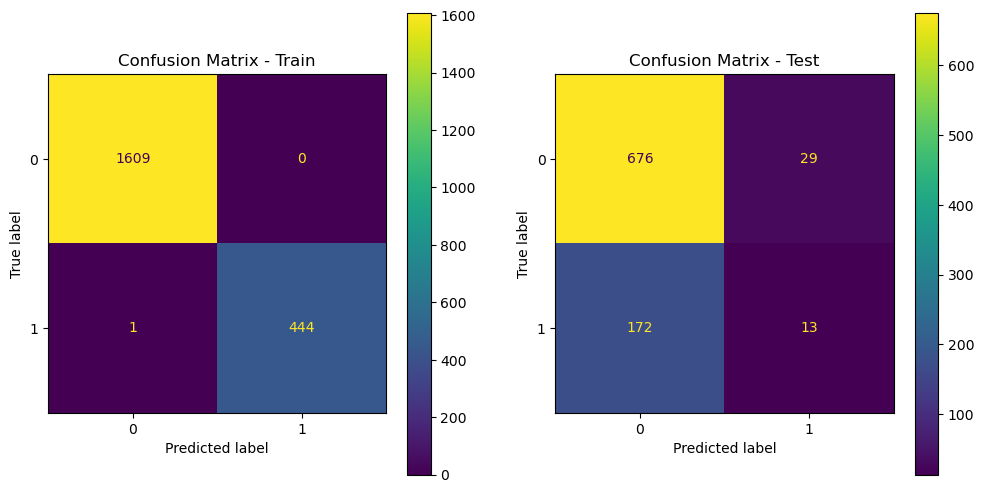

In [94]:
# membuat subplots dengan ukuran 12x6
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# menampilkan confusion matrix train pada subplot pertama
disp_train = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_pred_train_rf))
disp_train.plot(ax=ax[0], values_format='d')
ax[0].set_title('Confusion Matrix - Train')

# menampilkan confusion matrix test pada subplot kedua
disp_test = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, y_pred_test_rf))
disp_test.plot(ax=ax[1], values_format='d')
ax[1].set_title('Confusion Matrix - Test')

# menampilkan plot
plt.show()

#### Conclusion RandomForest

performa model RandomForest pada data training dan data testing untuk memprediksi kelas minoritas (1).

- Pada data train, model memiliki nilai precision yang cukup tinggi yaitu 0.9977. dan recall pada data train sangat bagus dengan nilai 1.0 atau 100%, yang mengindikasikan model dapat menjelaskan seluruh kelas minoritas.

- Pada data test, model memiliki nilai precision yang rendah yaitu hanya 0.266, yang artinya dari seluruh hasil prediksi yang benar, hanya 26.67% di antaranya benar-benar masuk dalam kelas yang dimaksud. Sementara itu, recall pada data test juga rendah hanya sebesar 0.064, yang mengindikasikan model memiliki kecenderungan untuk mengabaikan kelas minoritas.

Berdasarkan hasil ini, dapat disimpulkan bahwa model klasifikasi RandomForest ini memiliki masalah dalam mengidentifikasi kelas minoritas (kelas 1 pada data test) dan kemungkinan mengalami overfitting karena performanya yang baik pada data train tetapi buruk pada data test.

### GaussianNB

In [95]:
nb_params = {'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
# create the grid search object
grid_search_nb = GridSearchCV(pip_nb, nb_params, cv=5, scoring='recall', return_train_score=True)

# fit the grid search object to the training data
grid_search_nb.fit(X_train, y_train)

# print the best hyperparameters and test score
print("Best parameters: ", grid_search_nb.best_params_)
print("Test recall train: ", grid_search_nb.score(X_train, y_train))
print("Test recall test: ", grid_search_nb.score(X_test, y_test))

Best parameters:  {'classifier__var_smoothing': 1e-09}
Test recall train:  0.24943820224719102
Test recall test:  0.23243243243243245


dengan menggunakan grid_search untuk menentukan hyperparameter terbaik untuk model ini, ditemukan hyperparameternya adalah: `{'classifier__var_smoothing': 1e-09}`

- Dengan Nilai Recall data Train = 0.24943820224719102
- Dengan Nilai Recall data Test = 0.23243243243243245

Test recall train: 0.24943820224719102 menunjukkan performa recall pada data train sebesar 0.24943820224719102 sedangkan Test recall test: 0.23243243243243245 menunjukkan performa recall pada data test sebesar 0.23243243243243245. Semakin dekat nilai recall pada data train dan test, maka model akan semakin baik dalam melakukan generalisasi. 

In [96]:
cv_scores_nb = grid_search_nb.cv_results_['mean_test_score']
cv_std_nb = grid_search_nb.cv_results_['std_test_score']

print("mean_test_score: ", cv_scores_nb.mean())
print("std_test_score: ", cv_std_nb.mean())

mean_test_score:  0.22696629213483144
std_test_score:  0.05289259458849359


- mean_test_score adalah rata-rata skor pengujian dari model pada seluruh iterasi cross-validation yang dilakukan. Dalam kasus ini, nilai rata-rata skor pengujian adalah 0.22696629213483144

- std_test_score adalah simpangan baku dari skor pengujian dari model pada seluruh iterasi cross-validation yang dilakukan. Simpangan baku mengukur seberapa jauh nilai-nilai pengujian tersebar dari nilai rata-ratanya. Dalam kasus ini, nilai simpangan bakunya adalah 0.05289259458849359

In [97]:
# predict on the training data using the best model found by grid search
y_pred_train_nb = grid_search_nb.predict(X_train)

# predict on the test data using the best model found by grid search
y_pred_test_nb = grid_search_nb.predict(X_test)

In [98]:
auc_train = roc_auc_score(y_train, y_pred_train_nb)
auc_test = roc_auc_score(y_test, y_pred_test_nb)
print(f"AUC Train nb: {auc_train}" )
print(f"AUC score Test nb: {auc_test}")

AUC Train nb: 0.5579074168476477
AUC score Test nb: 0.5289821736630248


In [99]:
# Membandingkat nilai logistic train dan tes
#Classification Report Train
print('`Train Classification Report, gausianNB`')
print(classification_report(y_train, y_pred_train_nb))
print('Precision : ', precision_score(y_train, y_pred_train_nb))
print('Recall    : ', recall_score(y_train, y_pred_train_nb))

print(" ")
print(" ") # untuk enter
print(" ")

# Classification Report Test
print('`Test Classification Report, gausianNB`')
print(classification_report(y_test, y_pred_test_nb))
print('Precision : ', precision_score(y_test, y_pred_test_nb))
print('Recall    : ', recall_score(y_test, y_pred_test_nb))

`Train Classification Report, gausianNB`
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1609
           1       0.34      0.25      0.29       445

    accuracy                           0.73      2054
   macro avg       0.57      0.56      0.56      2054
weighted avg       0.71      0.73      0.72      2054

Precision :  0.34049079754601225
Recall    :  0.24943820224719102
 
 
 
`Test Classification Report, gausianNB`
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       705
           1       0.26      0.23      0.25       185

    accuracy                           0.70       890
   macro avg       0.53      0.53      0.53       890
weighted avg       0.69      0.70      0.70       890

Precision :  0.25903614457831325
Recall    :  0.23243243243243245


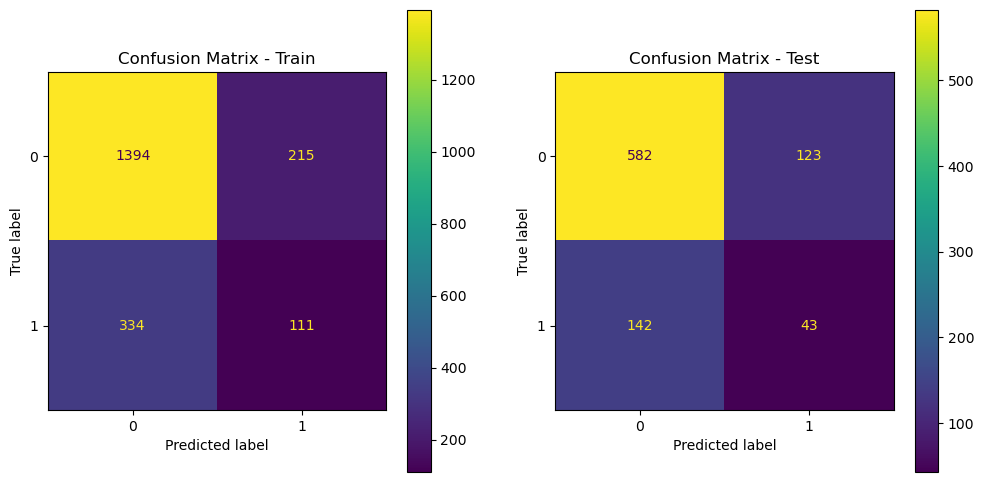

In [100]:
# membuat subplots dengan ukuran 12x6
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# menampilkan confusion matrix train pada subplot pertama
disp_train = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_pred_train_nb))
disp_train.plot(ax=ax[0], values_format='d')
ax[0].set_title('Confusion Matrix - Train')

# menampilkan confusion matrix test pada subplot kedua
disp_test = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, y_pred_test_nb))
disp_test.plot(ax=ax[1], values_format='d')
ax[1].set_title('Confusion Matrix - Test')

# menampilkan plot
plt.show()

#### Conclusion GaussianNB

performa model RandomForest pada data training dan data testing untuk memprediksi kelas minoritas (1).

- Pada data train, model Gaussian Naive Bayes memiliki precision sebesar 0.34 untuk kelas 1 (positif) dan recall sebesar 0.25. Hal ini berarti model tersebut dapat mengklasifikasikan 34% dari prediksi positifnya dengan benar dan 25% dari data aktual positif diidentifikasi secara benar.

- Pada data test, model Gaussian Naive Bayes memiliki precision sebesar 0.26 untuk kelas 1 (positif) dan recall sebesar 0.23. Hal ini berarti model tersebut dapat mengklasifikasikan 26% dari prediksi positifnya dengan benar dan 23% dari data aktual positif diidentifikasi secara benar.

Best parameters adalah parameter terbaik dari model Gaussian Naive Bayes yang diperoleh melalui tuning parameter dengan menggunakan GridSearchCV. parameter terbaik adalah 'var_smoothing' dengan nilai 1e-09. Test recall train dan test recall menunjukkan recall score pada data train dan data test. Pada model Gaussian Naive Bayes, recall pada data train adalah 0.24943820224719102 dan pada data test adalah 0.23243243243243245. Ini menunjukkan bahwa model tersebut dapat mengidentifikasi sekitar 25% dari data aktual positif pada data train dan 23% pada data test.

### KNN

#### Conceptual Problems

3. Bagaimana cara memilih K yang optimal pada KNN ?
Algoritma K-Nearest Neighbor (KNN) adalah metode pembelajaran mesin yang tidak parametrik yang digunakan untuk klasifikasi dan regresi. Salah satu aspek penting dari algoritma KNN adalah pemilihan nilai K yang optimal.

Berikut adalah beberapa metode yang dapat digunakan untuk memilih nilai K yang optimal pada KNN:

- Cross-validation: Cross-validation adalah metode yang umum digunakan untuk memilih nilai K yang optimal pada KNN. Metode ini melibatkan membagi data menjadi beberapa subset (biasanya 5 atau 10) dan melakukan pelatihan dan pengujian dengan memvariasikan nilai K pada setiap subset. Kemudian, rata-rata akurasi pengujian dari setiap subset digunakan untuk menentukan nilai K yang optimal.

- Grid search: Grid search adalah metode pencarian hiperparameter yang digunakan untuk menentukan nilai K yang optimal pada KNN. Metode ini melibatkan memvariasikan nilai K secara sistematis dan melakukan pelatihan dan pengujian pada setiap nilai K. Nilai K yang menghasilkan akurasi tertinggi pada pengujian digunakan sebagai nilai K yang optimal.

- Metode Elbow: Metode ini melibatkan plot grafik nilai K pada sumbu X dan akurasi pada sumbu Y. Kemudian, nilai K yang optimal dapat ditemukan pada titik di mana peningkatan akurasi terus menurun secara signifikan, seperti bentuk siku (elbow) pada grafik.

- Metode Density-Based: Metode ini melibatkan plot grafik nilai K pada sumbu X dan nilai kerapatan pada sumbu Y. Kemudian, nilai K yang optimal dapat ditemukan pada titik di mana nilai kerapatan mencapai titik jenuh, karena penambahan jumlah K tidak akan memberikan hasil yang lebih baik.

Pemilihan nilai K yang optimal sangat bergantung pada data dan masalah yang dihadapi. Oleh karena itu, penting untuk mencoba beberapa metode untuk memilih nilai K yang paling sesuai dengan data dan masalah yang dihadapi.

Dalam model KNN ini, digunakan Grid search untuk mencari K yang optimal


In [101]:
knn_params = {'classifier__n_neighbors': [5, 10, 15, 20], 
              'classifier__weights': ['uniform', 'distance'],
              'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
# create the grid search object
grid_search_knn = GridSearchCV(pip_knn, knn_params, cv=5, scoring='recall', return_train_score=True)

# fit the grid search object to the training data
grid_search_knn.fit(X_train, y_train)

# print the best hyperparameters and test score
print("Best parameters: ", grid_search_knn.best_params_)
print("Test recall train: ", grid_search_knn.score(X_train, y_train))
print("Test recall test: ", grid_search_knn.score(X_test, y_test))

Best parameters:  {'classifier__algorithm': 'auto', 'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}
Test recall train:  0.9977528089887641
Test recall test:  0.16756756756756758


dengan menggunakan grid_search untuk menentukan hyperparameter terbaik untuk model ini, ditemukan hyperparameternya adalah: `{'classifier__algorithm': 'auto', 'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}`

- Dengan Nilai Recall data Train = 0.9977528089887641
- Dengan Nilai Recall data Test = 0.16756756756756758

Hasil tersebut menunjukkan bahwa model memiliki recall yang sangat tinggi pada data train, yaitu sebesar 0.9977, namun memiliki recall yang rendah pada data test, yaitu sebesar 0.1675. Hal ini menunjukkan bahwa model cenderung overfitting, di mana model terlalu optimal untuk data train dan kurang optimal untuk data test.

In [102]:
cv_scores_knn = grid_search_knn.cv_results_['mean_test_score']
cv_std_knn = grid_search_knn.cv_results_['std_test_score']

print("mean_test_score: ", cv_scores_knn.mean())
print("std_test_score: ", cv_std_knn.mean())

mean_test_score:  0.06179775280898876
std_test_score:  0.019817308746312844


- mean_test_score adalah rata-rata skor pengujian dari model pada seluruh iterasi cross-validation yang dilakukan. Dalam kasus ini, nilai rata-rata skor pengujian adalah 0.06179775280898876

- std_test_score adalah simpangan baku dari skor pengujian dari model pada seluruh iterasi cross-validation yang dilakukan. Simpangan baku mengukur seberapa jauh nilai-nilai pengujian tersebar dari nilai rata-ratanya. Dalam kasus ini, nilai simpangan bakunya adalah 0.019817308746312844

In [103]:
# predict on the training data using the best model found by grid search
y_pred_train_knn = grid_search_knn.predict(X_train)

# predict on the test data using the best model found by grid search
y_pred_test_knn = grid_search_knn.predict(X_test)

In [104]:
auc_train = roc_auc_score(y_train, y_pred_train_knn)
auc_test = roc_auc_score(y_test, y_pred_test_knn)
print(f"AUC Train knn: {auc_train}" )
print(f"AUC score Test knn: {auc_test}")

AUC Train knn: 0.9988764044943821
AUC score Test knn: 0.5199539965497413


In [105]:
# Membandingkat nilai logistic train dan tes
#Classification Report Train
print('`Train Classification Report, KNN`')
print(classification_report(y_train, y_pred_train_knn))
print('Precision : ', precision_score(y_train, y_pred_train_knn))
print('Recall    : ', recall_score(y_train, y_pred_train_knn))

print(" ")
print(" ") # untuk enter
print(" ")

# Classification Report Test
print('`Test Classification Report, KNN`')
print(classification_report(y_test, y_pred_test_knn))
print('Precision : ', precision_score(y_test, y_pred_test_knn))
print('Recall    : ', recall_score(y_test, y_pred_test_knn))

`Train Classification Report, KNN`
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1609
           1       1.00      1.00      1.00       445

    accuracy                           1.00      2054
   macro avg       1.00      1.00      1.00      2054
weighted avg       1.00      1.00      1.00      2054

Precision :  1.0
Recall    :  0.9977528089887641
 
 
 
`Test Classification Report, KNN`
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       705
           1       0.26      0.17      0.20       185

    accuracy                           0.73       890
   macro avg       0.53      0.52      0.52       890
weighted avg       0.69      0.73      0.70       890

Precision :  0.256198347107438
Recall    :  0.16756756756756758


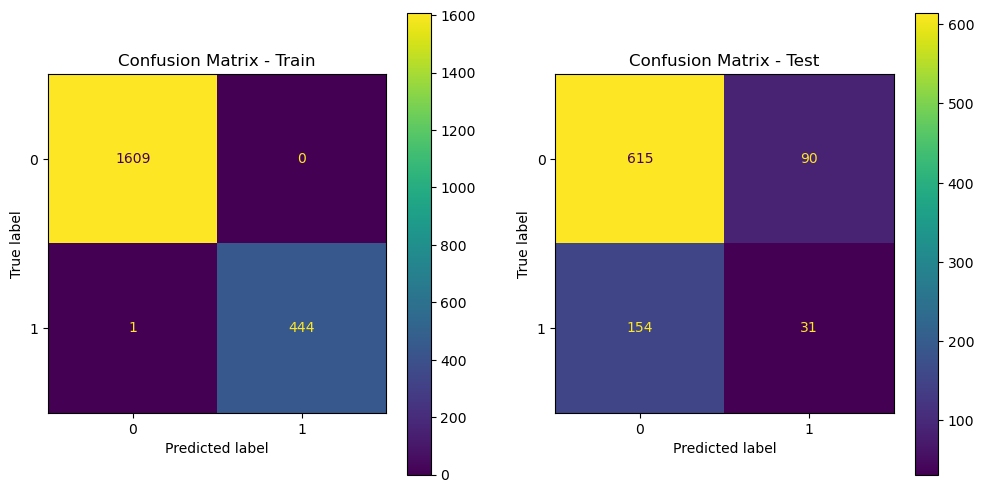

In [106]:
# membuat subplots dengan ukuran 12x6
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# menampilkan confusion matrix train pada subplot pertama
disp_train = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_pred_train_knn))
disp_train.plot(ax=ax[0], values_format='d')
ax[0].set_title('Confusion Matrix - Train')

# menampilkan confusion matrix test pada subplot kedua
disp_test = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, y_pred_test_knn))
disp_test.plot(ax=ax[1], values_format='d')
ax[1].set_title('Confusion Matrix - Test')

# menampilkan plot
plt.show()

#### Conclusion KNN

performa model KNN pada data training dan data testing untuk memprediksi kelas minoritas (1).

- Pada data train, model memiliki nilai precision yang cukup tinggi yaitu 1.0. dan recall pada data train sangat bagus dengan nilai 0.9977 atau 99,7%, yang mengindikasikan model dapat menjelaskan hampir seluruh kelas minoritas.

- Pada data test, model memiliki nilai precision yang rendah yaitu hanya 0.2561, yang artinya dari seluruh hasil prediksi yang benar, hanya 25.61% di antaranya benar-benar masuk dalam kelas yang dimaksud. Sementara itu, recall pada data test juga rendah hanya sebesar 0.167, yang mengindikasikan model memiliki kecenderungan untuk mengabaikan kelas minoritas.

Keluaran KNN menunjukkan performa yang baik pada data latih dengan precision 1.0 dan recall 0.997 untuk kelas 1. Namun, model juga menunjukkan overfitting pada data latih, dengan performa recall yang lebih rendah pada data uji (0.167).

### AdaBoostClassifier

In [107]:
ada_params = [{'classifier__n_estimators': [50, 100, 150], 
              'classifier__learning_rate': [0.01, 0.1, 1, 10]}]

# create the grid search object
grid_search_ada = GridSearchCV(pip_ada, ada_params, cv=5, scoring='recall', return_train_score=True)

# fit the grid search object to the training data
grid_search_ada.fit(X_train, y_train)

# print the best hyperparameters and test score
print("Best parameters: ", grid_search_ada.best_params_)
print("Test recall train: ", grid_search_ada.score(X_train, y_train))
print("Test recall test: ", grid_search_ada.score(X_test, y_test))

Best parameters:  {'classifier__learning_rate': 1, 'classifier__n_estimators': 150}
Test recall train:  0.06292134831460675
Test recall test:  0.02702702702702703


dengan menggunakan grid_search untuk menentukan hyperparameter terbaik untuk model ini, ditemukan hyperparameternya adalah: `{'classifier__learning_rate': 1, 'classifier__n_estimators': 150}`

- Dengan Nilai Recall data Train = 0.06292134831460675
- Dengan Nilai Recall data Test = 0.02702702702702703

Test recall train: 0.06292134831460675 adalah nilai recall (true positive rate) pada data training. Test recall test: 0.02702702702702703 adalah nilai recall pada data testing. Nilai recall yang rendah menunjukkan bahwa model cenderung salah mengklasifikasikan data kelas positif sebagai kelas negatif.

In [108]:
cv_scores_ada = grid_search_ada.cv_results_['mean_test_score']
cv_std_ada = grid_search_ada.cv_results_['std_test_score']

print("mean_test_score: ", cv_scores_ada.mean())
print("std_test_score: ", cv_std_ada.mean())

mean_test_score:  0.011423220973782773
std_test_score:  0.007106144820486216


- mean_test_score adalah rata-rata skor pengujian dari model pada seluruh iterasi cross-validation yang dilakukan. Dalam kasus ini, nilai rata-rata skor pengujian adalah 0.011423220973782773

- std_test_score adalah simpangan baku dari skor pengujian dari model pada seluruh iterasi cross-validation yang dilakukan. Simpangan baku mengukur seberapa jauh nilai-nilai pengujian tersebar dari nilai rata-ratanya. Dalam kasus ini, nilai simpangan bakunya adalah 0.007106144820486216

In [109]:
# predict on the training data using the best model found by grid search
y_pred_train_ada = grid_search_ada.predict(X_train)

# predict on the test data using the best model found by grid search
y_pred_test_ada = grid_search_ada.predict(X_test)

In [110]:
auc_train = roc_auc_score(y_train, y_pred_train_ada)
auc_test = roc_auc_score(y_test, y_pred_test_ada)
print(f"AUC Train ada: {auc_train}" )
print(f"AUC score Test ada: {auc_test}")

AUC Train ada: 0.5277316499186457
AUC score Test ada: 0.49861989649223687


In [111]:
# Membandingkat nilai logistic train dan tes
#Classification Report Train
print('`Train Classification Report, AdaBoostClassifier`')
print(classification_report(y_train, y_pred_train_ada))
print('Precision : ', precision_score(y_train, y_pred_train_ada))
print('Recall    : ', recall_score(y_train, y_pred_train_ada))

print(" ")
print(" ") # untuk enter
print(" ")

# Classification Report Test
print('`Test Classification Report, AdaBoostClassifier`')
print(classification_report(y_test, y_pred_test_ada))
print('Precision : ', precision_score(y_test, y_pred_test_ada))
print('Recall    : ', recall_score(y_test, y_pred_test_ada))

`Train Classification Report, AdaBoostClassifier`
              precision    recall  f1-score   support

           0       0.79      0.99      0.88      1609
           1       0.70      0.06      0.12       445

    accuracy                           0.79      2054
   macro avg       0.75      0.53      0.50      2054
weighted avg       0.77      0.79      0.72      2054

Precision :  0.7
Recall    :  0.06292134831460675
 
 
 
`Test Classification Report, AdaBoostClassifier`
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       705
           1       0.19      0.03      0.05       185

    accuracy                           0.77       890
   macro avg       0.49      0.50      0.46       890
weighted avg       0.67      0.77      0.70       890

Precision :  0.19230769230769232
Recall    :  0.02702702702702703


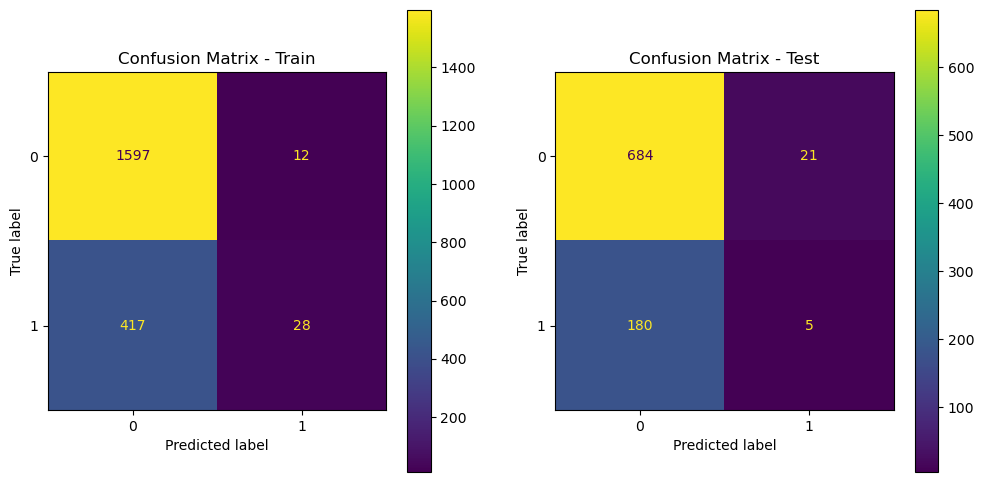

In [112]:
# membuat subplots dengan ukuran 12x6
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# menampilkan confusion matrix train pada subplot pertama
disp_train = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_pred_train_ada))
disp_train.plot(ax=ax[0], values_format='d')
ax[0].set_title('Confusion Matrix - Train')

# menampilkan confusion matrix test pada subplot kedua
disp_test = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, y_pred_test_ada))
disp_test.plot(ax=ax[1], values_format='d')
ax[1].set_title('Confusion Matrix - Test')

# menampilkan plot
plt.show()

## Compare Model

In [113]:
#pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', None)
])
# create a dictionary of hyperparameters for each model
param_grid = {
    'LogisticRegression': logreg_params,
    'DecisionTreeClassifier': dt_params,
    'SVM': svm_params,
    'RandomForestClassifier': rf_params,
    'GaussianNB': nb_params,
    'KNeighborsClassifier': knn_params,
    'AdaBoostClassifier': ada_params,
}

# create a dictionary of models
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'SVM': SVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GaussianNB': GaussianNB(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
}

In [114]:
for model_name, model in models.items():
    pipeline.set_params(classifier=model)
    if model_name in param_grid:
        grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=5, scoring= 'recall')
        grid_search.fit(X_test, y_test)
        print(f'{model_name} Best Parameters: {grid_search.best_params_}')
        print(f'{model_name} Best Test recall Score: {grid_search.best_score_}')

/Users/Devan/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
315 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Devan/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Devan/miniconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/Devan/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _ch

LogisticRegression Best Parameters: {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
LogisticRegression Best Test recall Score: 0.0
DecisionTreeClassifier Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_split': 2}
DecisionTreeClassifier Best Test recall Score: 0.2594594594594595
SVM Best Parameters: {'classifier__C': 10, 'classifier__degree': 4, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}
SVM Best Test recall Score: 0.021621621621621623
RandomForestClassifier Best Parameters: {'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
RandomForestClassifier Best Test recall Score: 0.05405405405405406
GaussianNB Best Parameters: {'classifier__var_smoothing': 1e-09}
GaussianNB Best Test recall Score: 0.20000000000000004
KNeighborsClassif

Model-model tersebut adalah:

1. Logistic Regression dengan parameter terbaik {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'} dan skor recall terbaik 0.0

2. Decision Tree dengan parameter terbaik {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_split': 2} dan skor recall terbaik 0.25405405405405407

3. SVM dengan parameter terbaik {'classifier__C': 10, 'classifier__degree': 4, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'} dan skor recall terbaik 0.021621621621621623
    
4. Random Forest dengan parameter terbaik {'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300} dan skor recall terbaik 0.05405405405405406

5. Gaussian Naive Bayes dengan parameter terbaik {'classifier__var_smoothing': 1e-09} dan skor recall terbaik 0.20000000000000004

6. K-Nearest Neighbors dengan parameter terbaik {'classifier__algorithm': 'auto', 'classifier__n_neighbors': 5, 'classifier__weights': 'distance'} dan skor recall terbaik 0.14054054054054052

7. AdaBoostClassifier dengan parameter terbaik {'classifier__learning_rate': 1, 'classifier__n_estimators': 150} dan skor recall terbaik 0.07027027027027027.

Dari hasil ini, maka model terbaik yang akan dipilih adalah `DecisionTreeClassifier` karena memiliki performa terbaik dengan recall sebesar 0.25405405405405407 pada data pengujian. Model ini menggunakan klasifikasi pohon keputusan dengan kriteria pembagian 'entropy', maksimum kedalaman tak terbatas, dan jumlah sampel minimum untuk membagi simpul adalah 2. Model ini memiliki keunggulan karena mudah diinterpretasikan dan tidak memerlukan banyak penyesuaian hyperparameter.

Dari Model-model yang sudah dilakukan diatas, 
- terdapat beberapa model yang bisa menjelaskan kelas minoritas pada data train= Decision Tree, Random Forest dan KNN
- untuk data test= tidak ada yang bisa menjelaskan kelas minoritas dengan baik

#### Conceptual Problems

4. Jelaskan apa yang dimaksud dengan Cross Validation !

    Cross-validation adalah teknik evaluasi model yang digunakan untuk mengukur kinerja model dan meminimalkan overfitting pada data. Teknik ini melibatkan pembagian data menjadi subset training dan testing yang saling terpisah, di mana data training digunakan untuk melatih model, dan data testing digunakan untuk mengukur kinerja model pada data yang belum pernah dilihat sebelumnya.

5. Apa yang dimaksud dengan metrics-metrics berikut : Accuracy, Precision, Recall, F1 Score, dan kapan waktu yang tepat untuk menggunakannya ?

- Accuracy = Mengukur seberapa banyak data yang benar diprediksi dibandingkan dengan total data (metriks ini sangat tidak disarankan digunakan untuk kasus data inbalance) "seperti data ini" `Metrik ini cocok digunakan ketika kelas target diimbangi (balanced class)`

- Precision= menggambarkan seberapa besar jumlah prediksi yang benar (biasanya fokus pada false positive yang harus rendah) `Metrik ini cocok digunakan ketika fokus pada ketepatan prediksi positif`

- Recall= menggambarkan jumlah data positif yang terprediksi positif (biasanya fokus pada false negative yang harus rendah) `Metrik ini cocok digunakan ketika fokus pada kemampuan model untuk menemukan semua kelas target positif`

- F1 Score = merata-ratakan nilai precision & recall. sangat bagus dihunakna jika recall dan precision seimbang `metrik yang baik untuk digunakan ketika kelas tidak seimbang.`



# Model Saving

Karena model pilihan adalah DecisionTreeClassifier, maka untuk data yang akan di saving adalah model DecisionTreeClassifier saja

In [115]:
with open('model_decision_tree_grid_search.pkl', 'wb') as file_2:
    joblib.dump(grid_search_dt, file_2)

with open('numeric_features.txt', 'wb') as file_3:
    joblib.dump(numeric_features, file_3)

## Data untuk Inference

In [116]:
inf =data.sample(30,random_state=0)
inf.to_csv('inf.csv', index=False)